In [ ]:
# import pandas as pd
# import torch
# from PIL import Image
# import requests
# from io import BytesIO
# from sentence_transformers import SentenceTransformer, util

# # Load dataset
# df = pd.read_csv("amazon_fashion_trimmed.csv")

# # Load CLIP model
# model = SentenceTransformer("clip-ViT-B-32")

# # Generate embeddings
# text_embeddings = model.encode(df["title"].tolist(), convert_to_tensor=True)

# image_embeddings = []
# for url in df["image_large"]:
#     try:
#         img = Image.open(BytesIO(requests.get(url).content)).convert("RGB")
#         image_embeddings.append(model.encode(img, convert_to_tensor=True))
#     except:
#         image_embeddings.append(torch.zeros(text_embeddings.shape[1]))  # fallback

# image_embeddings = torch.stack(image_embeddings)

# # Fusion (equal weights here, can be dynamic later)
# fused_embeddings = 0.5 * text_embeddings + 0.5 * image_embeddings
# fused_embeddings = torch.nn.functional.normalize(fused_embeddings, p=2, dim=1)

# # Recommendation function
# def recommend(idx, top_k=5):
#     query_emb = fused_embeddings[idx]
#     scores = util.cos_sim(query_emb, fused_embeddings)[0]
#     top_results = torch.topk(scores, k=top_k + 1)
    
#     print(f"Query: {df.iloc[idx]['title']}")
#     for score, i in zip(top_results[0][1:], top_results[1][1:]):  # skip itself
#         print(f"{df.iloc[i]['title']} (score: {score:.4f})")

# # Example
# recommend(0, top_k=5)


In [ ]:
# import os
# import pandas as pd
# import torch
# from PIL import Image
# import requests
# from io import BytesIO
# from sentence_transformers import SentenceTransformer, util
# from concurrent.futures import ThreadPoolExecutor
# import pickle

# # ===============================
# # CONFIG
# # ===============================
# DATA_FILE = "amazon_fashion_trimmed.csv"
# TEXT_EMB_CACHE = "text_embeddings.pt"
# IMAGE_EMB_CACHE = "image_embeddings.pt"
# MODEL_NAME = "clip-ViT-B-32"
# NUM_THREADS = 8  # Parallel image downloads
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# # ===============================
# # Load dataset
# # ===============================
# df = pd.read_csv(DATA_FILE)

# # ===============================
# # Load CLIP model
# # ===============================
# model = SentenceTransformer(MODEL_NAME, device=DEVICE)

# # ===============================
# # Encode text (cached)
# # ===============================
# # if os.path.exists(TEXT_EMB_CACHE):
# #     print("Loading cached text embeddings...")
# #     text_embeddings = torch.load(TEXT_EMB_CACHE, map_location=DEVICE)
# # else:
# #     print("Generating text embeddings...")
# #     text_embeddings = model.encode(df["title"].tolist(), convert_to_tensor=True, show_progress_bar=True)
# #     torch.save(text_embeddings, TEXT_EMB_CACHE)
# print("Generating text embeddings...")
# text_embeddings = model.encode(df["title"].tolist(), convert_to_tensor=True, show_progress_bar=True)

# # ===============================
# # Encode images in parallel (cached)
# # ===============================
# # def process_image(url):
# #     try:
# #         img = Image.open(BytesIO(requests.get(url, timeout=5).content)).convert("RGB")
# #         return model.encode(img, convert_to_tensor=True)
# #     except Exception as e:
# #         return torch.zeros(text_embeddings.shape[1])  # Fallback for failed images

# # if os.path.exists(IMAGE_EMB_CACHE):
# #     print("Loading cached image embeddings...")
# #     image_embeddings = torch.load(IMAGE_EMB_CACHE, map_location=DEVICE)
# # else:
# #     print("Downloading & encoding images in parallel...")
# #     with ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
# #         image_embeddings_list = list(executor.map(process_image, df["image_large"].tolist()))
# #     image_embeddings = torch.stack(image_embeddings_list)
# #     torch.save(image_embeddings, IMAGE_EMB_CACHE)

# def process_image(url):
#     try:
#         img = Image.open(BytesIO(requests.get(url, timeout=5).content)).convert("RGB")
#         return model.encode(img, convert_to_tensor=True)
#     except Exception:
#         return torch.zeros(text_embeddings.shape[1])  # Fallback for failed images

# print("Downloading & encoding images in parallel...")
# with ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
#     image_embeddings_list = list(executor.map(process_image, df["image_large"].tolist()))
# image_embeddings = torch.stack(image_embeddings_list)


# # ===============================
# # Fusion (equal weight for now)
# # ===============================
# fused_embeddings = 0.5 * text_embeddings + 0.5 * image_embeddings
# fused_embeddings = torch.nn.functional.normalize(fused_embeddings, p=2, dim=1)

# # ===============================
# # Recommendation function
# # ===============================
# def recommend(idx, top_k=5):
#     query_emb = fused_embeddings[idx]
#     scores = util.cos_sim(query_emb, fused_embeddings)[0]
#     top_results = torch.topk(scores, k=top_k + 1)

#     print(f"\nQuery: {df.iloc[idx]['title']}")
#     for score, i in zip(top_results[0][1:], top_results[1][1:]):  # skip itself
#         i = int(i)  # Convert tensor to int
#         print(f"{df.iloc[i]['title']} (score: {score.item():.4f})")

# # ===============================
# # Example usage
# # ===============================
# recommend(0, top_k=5)


In [ ]:
# from IPython.display import display

# def recommend(idx, top_k=5):
#     query_emb = fused_embeddings[idx]
#     scores = util.cos_sim(query_emb, fused_embeddings)[0]
#     top_results = torch.topk(scores, k=top_k + 1)

#     # Show the query item
#     print(f"\nQuery: {df.iloc[idx]['title']}")
#     try:
#         img = Image.open(BytesIO(requests.get(df.iloc[idx]['image_large']).content)).convert("RGB")
#         display(img)
#     except:
#         print("[Image not available]")

#     # Show recommendations
#     print("\nTop Recommendations:")
#     for score, i in zip(top_results[0][1:], top_results[1][1:]):  # skip itself
#         i = int(i)  # Convert tensor to int
#         print(f"{df.iloc[i]['title']} (score: {score.item():.4f})")
#         try:
#             img = Image.open(BytesIO(requests.get(df.iloc[i]['image_large']).content)).convert("RGB")
#             display(img)
#         except:
#             print("[Image not available]")


In [ ]:
import os
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer, util

# ===============================
# CONFIG
# ===============================
DATA_FILE = "amazon_fashion_trimmed_10000.csv"
TEXT_EMB_CACHE = "text_embeddings.pt"
IMAGE_EMB_CACHE = "image_embeddings.pt"
MODEL_NAME = "clip-ViT-B-32"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ===============================
# Load dataset
# ===============================
df = pd.read_csv(DATA_FILE)

# ===============================
# Load CLIP model
# ===============================
model = SentenceTransformer(MODEL_NAME, device=DEVICE)

# ===============================
# Load cached text embeddings
# ===============================
if os.path.exists(TEXT_EMB_CACHE):
    print("Loading cached text embeddings...")
    text_embeddings = torch.load(TEXT_EMB_CACHE, map_location=DEVICE)
else:
    print("Generating text embeddings...")
    text_embeddings = model.encode(df["title"].tolist(), convert_to_tensor=True, show_progress_bar=True)
    torch.save(text_embeddings, TEXT_EMB_CACHE)

# ===============================
# Load cached image embeddings
# ===============================
if os.path.exists(IMAGE_EMB_CACHE):
    print("Loading cached image embeddings...")
    img_cache = torch.load(IMAGE_EMB_CACHE, map_location=DEVICE)
    
    # If the cache is a dict, convert to tensor in the same order as df
    if isinstance(img_cache, dict):
        image_embeddings = torch.stack([img_cache[path] for path in df["image_large"]])
    else:
        image_embeddings = img_cache
else:
    raise FileNotFoundError(f"{IMAGE_EMB_CACHE} not found! Please generate and save it first.")

# ===============================
# Fusion (equal weight for now)
# ===============================
fused_embeddings = 0.35 * text_embeddings + 0.65 * image_embeddings
fused_embeddings = torch.nn.functional.normalize(fused_embeddings, p=2, dim=1)

# ===============================
# Recommendation function
# ===============================
def recommend(idx, top_k=5):
    query_emb = fused_embeddings[idx]
    scores = util.cos_sim(query_emb, fused_embeddings)[0]
    top_results = torch.topk(scores, k=top_k + 1)

    # Show the query item
    print(f"\nQuery: {df.iloc[idx]['title']}")
    try:
        img = Image.open(BytesIO(requests.get(df.iloc[idx]['image_large']).content)).convert("RGB")
        display(img)
    except:
        print("[Image not available]")

    # Show recommendations
    print("\nTop Recommendations:")
    for score, i in zip(top_results[0][1:], top_results[1][1:]):  # skip itself
        i = int(i)  # Convert tensor to int
        print(f"{df.iloc[i]['title']} (score: {score.item():.4f})")
        try:
            img = Image.open(BytesIO(requests.get(df.iloc[i]['image_large']).content)).convert("RGB")
            display(img)
        except:
            print("[Image not available]")

# ===============================
# Example usage
# ===============================
# recommend(0, top_k=5)


In [ ]:
recommend(8682, top_k=5)

FUSION AND HEIRARCHICAL

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm

# ===============================
# CONFIG
# ===============================
DATA_FILE = "amazon_fashion_trimmed_10000.csv"
TEXT_EMB_CACHE = "text_embeddings.pt"
IMAGE_EMB_CACHE = "image_embeddings.pt"
MODEL_NAME = "clip-ViT-B-32"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ===============================
# Load dataset
# ===============================
df = pd.read_csv(DATA_FILE)

# ===============================
# Load CLIP model
# ===============================
model = SentenceTransformer(MODEL_NAME, device=DEVICE)

# ===============================
# Load cached text embeddings
# ===============================
if os.path.exists(TEXT_EMB_CACHE):
    print("Loading cached text embeddings...")
    text_embeddings = torch.load(TEXT_EMB_CACHE, map_location=DEVICE)
else:
    print("Generating text embeddings...")
    text_embeddings = model.encode(df["title"].tolist(), convert_to_tensor=True, show_progress_bar=True)
    torch.save(text_embeddings, TEXT_EMB_CACHE)

# ===============================
# Load cached image embeddings
# ===============================
if os.path.exists(IMAGE_EMB_CACHE):
    print("Loading cached image embeddings...")
    img_cache = torch.load(IMAGE_EMB_CACHE, map_location=DEVICE)
    
    if isinstance(img_cache, dict):
        image_embeddings = torch.stack([img_cache[path] for path in df["image_large"]])
    else:
        image_embeddings = img_cache
else:
    raise FileNotFoundError(f"{IMAGE_EMB_CACHE} not found! Please generate and save it first.")


# ===============================
# Hierarchical Attention Module
# ===============================
class HierarchicalAttentionFusion(nn.Module):
    def __init__(self, embed_dim, hidden_dim=128):
        super().__init__()
        # Intra-modal attention
        self.text_att = nn.Linear(embed_dim, 1)
        self.image_att = nn.Linear(embed_dim, 1)

        # Inter-modal attention
        self.fusion_att = nn.Sequential(
            nn.Linear(embed_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, text_emb, image_emb):
        # Intra-modal attention
        text_w = torch.sigmoid(self.text_att(text_emb))
        img_w  = torch.sigmoid(self.image_att(image_emb))
        text_rep = text_w * text_emb
        img_rep  = img_w * image_emb

        # Inter-modal attention
        fusion_input = torch.cat([text_rep, img_rep], dim=-1)
        fusion_logits = self.fusion_att(fusion_input)
        fusion_weights = F.softmax(fusion_logits, dim=-1)  # (N,2)

        fused = fusion_weights[:,0].unsqueeze(1) * text_rep + \
                fusion_weights[:,1].unsqueeze(1) * img_rep
        fused = F.normalize(fused, p=2, dim=1)
        return fused, fusion_weights


# ===============================
# Apply fusion
# ===============================
fusion_model = HierarchicalAttentionFusion(embed_dim=text_embeddings.shape[1]).to(DEVICE)

fusion_model.eval()
with torch.no_grad():
    fused_embeddings, fusion_weights = fusion_model(text_embeddings, image_embeddings)

print("Fused embeddings shape:", fused_embeddings.shape)


# ===============================
# Recommendation function
# ===============================
def recommend(idx, top_k=5):
    query_emb = fused_embeddings[idx]
    scores = util.cos_sim(query_emb, fused_embeddings)[0]
    top_results = torch.topk(scores, k=top_k + 1)

    print(f"\nQuery: {df.iloc[idx]['title']}")
    try:
        img = Image.open(BytesIO(requests.get(df.iloc[idx]['image_large']).content)).convert("RGB")
        display(img)
    except:
        print("[Image not available]")

    print("\nTop Recommendations:")
    for score, i in zip(top_results[0][1:], top_results[1][1:]):
        i = int(i)
        print(f"{df.iloc[i]['title']} (score: {score.item():.4f}) | Weights (T:{fusion_weights[i,0]:.2f}, I:{fusion_weights[i,1]:.2f})")
        try:
            img = Image.open(BytesIO(requests.get(df.iloc[i]['image_large']).content)).convert("RGB")
            display(img)
        except:
            print("[Image not available]")


# ===============================
# Evaluation Metrics
# ===============================
def evaluate_retrieval(text_embs, image_embs, k_values=[1,5,10]):
    metrics = {"text2image": {}, "image2text": {}}
    
    # ---------- Text → Image ----------
    sims = util.cos_sim(text_embs, image_embs)  # (N,N)
    ranks = torch.argsort(sims, dim=-1, descending=True)

    recall_scores, mrr_scores = {k:0 for k in k_values}, []
    for i in tqdm(range(len(text_embs)), desc="Text→Image Eval"):
        ranking = ranks[i].tolist()
        rank_pos = ranking.index(i)  # where is the correct image?
        mrr_scores.append(1.0 / (rank_pos+1))
        for k in k_values:
            if rank_pos < k:
                recall_scores[k] += 1

    metrics["text2image"]["MRR"] = sum(mrr_scores)/len(mrr_scores)
    for k in k_values:
        metrics["text2image"][f"Recall@{k}"] = recall_scores[k]/len(text_embs)

    # ---------- Image → Text ----------
    sims = util.cos_sim(image_embs, text_embs)
    ranks = torch.argsort(sims, dim=-1, descending=True)

    recall_scores, mrr_scores = {k:0 for k in k_values}, []
    for i in tqdm(range(len(image_embs)), desc="Image→Text Eval"):
        ranking = ranks[i].tolist()
        rank_pos = ranking.index(i)
        mrr_scores.append(1.0 / (rank_pos+1))
        for k in k_values:
            if rank_pos < k:
                recall_scores[k] += 1

    metrics["image2text"]["MRR"] = sum(mrr_scores)/len(mrr_scores)
    for k in k_values:
        metrics["image2text"][f"Recall@{k}"] = recall_scores[k]/len(image_embs)

    return metrics


# ===============================
# Run Evaluation
# ===============================
results = evaluate_retrieval(fused_embeddings, fused_embeddings)  # fused vs fused (self-retrieval)
print("\nRetrieval Results:")
for task, vals in results.items():
    print(f"\n{task.upper()}:")
    for k,v in vals.items():
        print(f"  {k}: {v:.4f}")


In [ ]:
recommend(96, top_k=5)

For self retrieval verification

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import requests
from io import BytesIO

# ===============================
# CONFIG
# ===============================
DATA_FILE = "amazon_fashion_trimmed_10000.csv"
TEXT_EMB_CACHE = "text_embeddings.pt"
IMAGE_EMB_CACHE = "image_embeddings.pt"
MODEL_NAME = "clip-ViT-B-32"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float32

# ===============================
# Load dataset
# ===============================
df = pd.read_csv(DATA_FILE)

# ===============================
# Load CLIP model
# ===============================
model = SentenceTransformer(MODEL_NAME, device=DEVICE)

# ===============================
# Load cached text embeddings
# ===============================
if os.path.exists(TEXT_EMB_CACHE):
    print("Loading cached text embeddings...")
    text_embeddings = torch.load(TEXT_EMB_CACHE, map_location=DEVICE)
else:
    print("Generating text embeddings...")
    text_embeddings = model.encode(
        df["title"].tolist(),
        convert_to_tensor=True,
        show_progress_bar=True
    )
    torch.save(text_embeddings, TEXT_EMB_CACHE)

# Ensure dtype/device
text_embeddings = text_embeddings.to(device=DEVICE, dtype=DTYPE)

# ===============================
# Load cached image embeddings
# ===============================
if not os.path.exists(IMAGE_EMB_CACHE):
    raise FileNotFoundError(f"{IMAGE_EMB_CACHE} not found! Please generate and save it first.")

print("Loading cached image embeddings...")
img_cache = torch.load(IMAGE_EMB_CACHE, map_location=DEVICE)

if isinstance(img_cache, dict):
    # Reconstruct in the same row order as the CSV
    missing = [u for u in df["image_large"] if u not in img_cache]
    if missing:
        print(f"[WARN] {len(missing)} urls from CSV not found in cache. They will be zeroed.")
    image_embeddings_list = []
    # Determine embedding dim robustly
    some_vec = None
    for v in img_cache.values():
        if isinstance(v, torch.Tensor) and v.numel() > 0:
            some_vec = v
            break
    if some_vec is None:
        raise ValueError("Image embedding cache is empty or invalid.")
    emb_dim = some_vec.shape[-1]

    for url in df["image_large"]:
        if url in img_cache and isinstance(img_cache[url], torch.Tensor) and img_cache[url].numel() == emb_dim:
            image_embeddings_list.append(img_cache[url].to(device=DEVICE, dtype=DTYPE))
        else:
            image_embeddings_list.append(torch.zeros(emb_dim, device=DEVICE, dtype=DTYPE))
    image_embeddings = torch.stack(image_embeddings_list)
else:
    image_embeddings = img_cache.to(device=DEVICE, dtype=DTYPE)

# Optional: safety normalization (helps retrieval stability)
def l2_normalize(x, eps=1e-12):
    return x / (x.norm(p=2, dim=1, keepdim=True).clamp_min(eps))

# ===============================
# Hierarchical Attention Module
# ===============================
class HierarchicalAttentionFusion(nn.Module):
    def __init__(self, embed_dim, hidden_dim=128):
        super().__init__()
        # Intra-modal gates
        self.text_att = nn.Linear(embed_dim, 1)
        self.image_att = nn.Linear(embed_dim, 1)
        # Inter-modal router
        self.fusion_att = nn.Sequential(
            nn.Linear(embed_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, text_emb, image_emb):
        # Intra-modal gating
        text_w = torch.sigmoid(self.text_att(text_emb))        # (N,1)
        img_w  = torch.sigmoid(self.image_att(image_emb))      # (N,1)
        text_rep = text_w * text_emb                           # (N,d)
        img_rep  = img_w  * image_emb                          # (N,d)

        # Inter-modal attention
        fusion_input  = torch.cat([text_rep, img_rep], dim=-1) # (N,2d)
        fusion_logits = self.fusion_att(fusion_input)          # (N,2)
        fusion_weights = F.softmax(fusion_logits, dim=-1)      # (N,2)

        fused = fusion_weights[:, 0].unsqueeze(1) * text_rep + \
                fusion_weights[:, 1].unsqueeze(1) * img_rep
        fused = F.normalize(fused, p=2, dim=1)
        return fused, fusion_weights

# ===============================
# Apply fusion (untrained for now)
# ===============================
fusion_model = HierarchicalAttentionFusion(embed_dim=text_embeddings.shape[1]).to(DEVICE)
fusion_model.eval()
with torch.no_grad():
    fused_embeddings, fusion_weights = fusion_model(text_embeddings, image_embeddings)

print("Fused embeddings shape:", fused_embeddings.shape)
print("Example fusion weights (text vs image):", fusion_weights[:5])

# ===============================
# Proxy Evaluation: Exact Self-Retrieval
#   We evaluate Text→Image and Image→Text separately.
#   Ground truth for item i is index i on the opposite modality.
# ===============================
def recall_mrr_text_to_image(text_embs, image_embs, top_k_list=[1,5,10], batch_size=512):
    text_embs = l2_normalize(text_embs)
    image_embs = l2_normalize(image_embs)

    n = text_embs.shape[0]
    recalls = {k: 0 for k in top_k_list}
    mrr_total = 0.0

    # Compute in batches to control memory
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        q = text_embs[start:end]                    # (B,d)
        scores = q @ image_embs.T                   # (B,N)

        # For each row b, correct index is (start+b)
        for b in range(scores.size(0)):
            correct = start + b
            # Sort descending similarities
            vals, idxs = torch.topk(scores[b], k=max(top_k_list))
            idxs = idxs.tolist()

            # Find rank of the correct index
            found_rank = None
            for rank, j in enumerate(idxs, start=1):
                if j == correct:
                    found_rank = rank
                    break

            if found_rank is not None:
                for k in top_k_list:
                    if found_rank <= k:
                        recalls[k] += 1
                mrr_total += 1.0 / found_rank

    results = {f"Recall@{k}": recalls[k] / n for k in top_k_list}
    results["MRR"] = mrr_total / n
    return results

def recall_mrr_image_to_text(image_embs, text_embs, top_k_list=[1,5,10], batch_size=512):
    # symmetric to the above
    return recall_mrr_text_to_image(image_embs, text_embs, top_k_list=top_k_list, batch_size=batch_size)

# Run proxy evaluations
print("\nProxy Evaluation (Exact Self-Retrieval):")
metrics_t2i = recall_mrr_text_to_image(text_embeddings, image_embeddings, top_k_list=[1,5,10])
metrics_i2t = recall_mrr_image_to_text(image_embeddings, text_embeddings, top_k_list=[1,5,10])

print("Text → Image:")
for k, v in metrics_t2i.items():
    print(f"  {k}: {v:.4f}")

print("Image → Text:")
for k, v in metrics_i2t.items():
    print(f"  {k}: {v:.4f}")

# ===============================
# Recommendation function (fused→fused)
# ===============================
def recommend(idx, top_k=5):
    query_emb = fused_embeddings[idx]
    scores = util.cos_sim(query_emb, fused_embeddings)[0]
    top_results = torch.topk(scores, k=top_k + 1)

    # Show the query item
    print(f"\nQuery: {df.iloc[idx]['title']}")
    try:
        img = Image.open(BytesIO(requests.get(df.iloc[idx]['image_large']).content)).convert("RGB")
        display(img)
    except:
        print("[Image not available]")

    # Show recommendations
    print("\nTop Recommendations:")
    for score, i in zip(top_results[0][1:], top_results[1][1:]):
        i = int(i)
        print(f"{df.iloc[i]['title']} (score: {score.item():.4f}) | Weights (T:{fusion_weights[i,0]:.2f}, I:{fusion_weights[i,1]:.2f})")
        try:
            img = Image.open(BytesIO(requests.get(df.iloc[i]['image_large']).content)).convert("RGB")
            display(img)
        except:
            print("[Image not available]")
# ===============================
# Example usage
# ===============================
# recommend(0, top_k=5)


Attentiton training

In [ ]:
recommend(900, top_k=5)

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import requests
from io import BytesIO

# ===============================
# CONFIG
# ===============================
DATA_FILE = "amazon_fashion_trimmed_10000.csv"
TEXT_EMB_CACHE = "text_embeddings.pt"
IMAGE_EMB_CACHE = "image_embeddings.pt"
FUSION_CHECKPOINT = "fusion_checkpoint.pt"
MODEL_NAME = "clip-ViT-B-32"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float32

# Training hyperparams (tune as needed)
EPOCHS = 5
BATCH_SIZE = 512
LR = 1e-4
WEIGHT_DECAY = 1e-6
TEMPERATURE = 0.07
PRINT_EVERY = 50
SAVE_EVERY = 1  # epochs

# ===============================
# Load dataset
# ===============================
df = pd.read_csv(DATA_FILE)

# ===============================
# Load CLIP model
# ===============================
model = SentenceTransformer(MODEL_NAME, device=DEVICE)

# ===============================
# Load cached text embeddings
# ===============================
if os.path.exists(TEXT_EMB_CACHE):
    print("Loading cached text embeddings...")
    text_embeddings = torch.load(TEXT_EMB_CACHE, map_location=DEVICE)
else:
    print("Generating text embeddings...")
    text_embeddings = model.encode(
        df["title"].tolist(),
        convert_to_tensor=True,
        show_progress_bar=True
    )
    torch.save(text_embeddings, TEXT_EMB_CACHE)

# Ensure dtype/device
text_embeddings = text_embeddings.to(device=DEVICE, dtype=DTYPE)

# ===============================
# Load cached image embeddings
# ===============================
if not os.path.exists(IMAGE_EMB_CACHE):
    raise FileNotFoundError(f"{IMAGE_EMB_CACHE} not found! Please generate and save it first.")

print("Loading cached image embeddings...")
img_cache = torch.load(IMAGE_EMB_CACHE, map_location=DEVICE)

if isinstance(img_cache, dict):
    # Reconstruct in the same row order as the CSV
    missing = [u for u in df["image_large"] if u not in img_cache]
    if missing:
        print(f"[WARN] {len(missing)} urls from CSV not found in cache. They will be zeroed.")
    image_embeddings_list = []
    # Determine embedding dim robustly
    some_vec = None
    for v in img_cache.values():
        if isinstance(v, torch.Tensor) and v.numel() > 0:
            some_vec = v
            break
    if some_vec is None:
        raise ValueError("Image embedding cache is empty or invalid.")
    emb_dim = some_vec.shape[-1]

    for url in df["image_large"]:
        if url in img_cache and isinstance(img_cache[url], torch.Tensor) and img_cache[url].numel() == emb_dim:
            image_embeddings_list.append(img_cache[url].to(device=DEVICE, dtype=DTYPE))
        else:
            image_embeddings_list.append(torch.zeros(emb_dim, device=DEVICE, dtype=DTYPE))
    image_embeddings = torch.stack(image_embeddings_list)
else:
    image_embeddings = img_cache.to(device=DEVICE, dtype=DTYPE)

# Optional: safety normalization (helps retrieval stability)
def l2_normalize(x, eps=1e-12):
    return x / (x.norm(p=2, dim=1, keepdim=True).clamp_min(eps))

# ===============================
# Hierarchical Attention Module
# ===============================
class HierarchicalAttentionFusion(nn.Module):
    def __init__(self, embed_dim, hidden_dim=128):
        super().__init__()
        # Intra-modal gates
        self.text_att = nn.Linear(embed_dim, 1)
        self.image_att = nn.Linear(embed_dim, 1)
        # Inter-modal router
        self.fusion_att = nn.Sequential(
            nn.Linear(embed_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, text_emb, image_emb):
        # Intra-modal gating
        text_w = torch.sigmoid(self.text_att(text_emb))        # (N,1)
        img_w  = torch.sigmoid(self.image_att(image_emb))      # (N,1)
        text_rep = text_w * text_emb                           # (N,d)
        img_rep  = img_w  * image_emb                          # (N,d)

        # Inter-modal attention
        fusion_input  = torch.cat([text_rep, img_rep], dim=-1) # (N,2d)
        fusion_logits = self.fusion_att(fusion_input)          # (N,2)
        fusion_weights = F.softmax(fusion_logits, dim=-1)      # (N,2)

        fused = fusion_weights[:, 0].unsqueeze(1) * text_rep + \
                fusion_weights[:, 1].unsqueeze(1) * img_rep
        fused = F.normalize(fused, p=2, dim=1)
        return fused, fusion_weights

# ===============================
# Instantiate fusion model
# ===============================
fusion_model = HierarchicalAttentionFusion(embed_dim=text_embeddings.shape[1]).to(DEVICE)

# Optional: resume checkpoint
start_epoch = 0
if os.path.exists(FUSION_CHECKPOINT):
    try:
        ckpt = torch.load(FUSION_CHECKPOINT, map_location=DEVICE)
        fusion_model.load_state_dict(ckpt["model_state"])
        start_epoch = ckpt.get("epoch", 0) + 1
        print(f"[INFO] Loaded fusion checkpoint from epoch {ckpt.get('epoch', 'unknown')}")
    except Exception as e:
        print(f"[WARN] Failed to load checkpoint: {e}")

# ===============================
# Training utilities
# ===============================
optimizer = torch.optim.AdamW(fusion_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

def train_fusion(text_embs, image_embs, model, epochs=EPOCHS, batch_size=BATCH_SIZE, device=DEVICE, temp=TEMPERATURE):
    model.train()
    n = text_embs.shape[0]
    idxs = torch.arange(n, device=device)
    for epoch in range(start_epoch, start_epoch + epochs):
        perm = torch.randperm(n, device=device)
        running_loss = 0.0
        it = 0
        for s in range(0, n, batch_size):
            e = min(s + batch_size, n)
            batch_idx = perm[s:e]
            t_b = text_embs[batch_idx]
            i_b = image_embs[batch_idx]

            # Forward fused
            fused_b, _ = model(t_b, i_b)  # (B, d)

            # Normalize (already normalized in model but ensure numerical)
            fused_b = F.normalize(fused_b, p=2, dim=1)
            t_b_n = F.normalize(t_b, p=2, dim=1)
            i_b_n = F.normalize(i_b, p=2, dim=1)

            # Similarity matrices (B x B)
            logits_ft = (fused_b @ t_b_n.T) / temp
            logits_fi = (fused_b @ i_b_n.T) / temp

            labels = torch.arange(logits_ft.size(0), device=device)

            loss_ft = F.cross_entropy(logits_ft, labels)
            loss_fi = F.cross_entropy(logits_fi, labels)
            loss = loss_ft + loss_fi

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            it += 1
            if it % PRINT_EVERY == 0:
                print(f"Epoch {epoch} | iter {it} | avg loss: {running_loss/it:.4f}")

        scheduler.step()
        avg_epoch_loss = running_loss / max(1, it)
        print(f"Epoch {epoch} completed. Avg loss: {avg_epoch_loss:.4f}")

        # Save checkpoint
        if (epoch + 1) % SAVE_EVERY == 0:
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }, FUSION_CHECKPOINT)
            print(f"[INFO] Checkpoint saved at epoch {epoch}")

# ===============================
# Evaluation helpers
# ===============================
def recall_mrr_text_to_image(text_embs, image_embs, top_k_list=[1,5,10], batch_size=512):
    text_embs = l2_normalize(text_embs)
    image_embs = l2_normalize(image_embs)

    n = text_embs.shape[0]
    recalls = {k: 0 for k in top_k_list}
    mrr_total = 0.0

    # Compute in batches to control memory
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        q = text_embs[start:end]                    # (B,d)
        scores = q @ image_embs.T                   # (B,N)

        # For each row b, correct index is (start+b)
        for b in range(scores.size(0)):
            correct = start + b
            # Sort descending similarities
            vals, idxs = torch.topk(scores[b], k=max(top_k_list))
            idxs = idxs.tolist()

            # Find rank of the correct index
            found_rank = None
            for rank, j in enumerate(idxs, start=1):
                if j == correct:
                    found_rank = rank
                    break

            if found_rank is not None:
                for k in top_k_list:
                    if found_rank <= k:
                        recalls[k] += 1
                mrr_total += 1.0 / found_rank

    results = {f"Recall@{k}": recalls[k] / n for k in top_k_list}
    results["MRR"] = mrr_total / n
    return results

def recall_mrr_fused(fused_embs, top_k_list=[1,5,10], batch_size=512):
    # Self-retrieval: ground truth for i is i
    fused_embs = l2_normalize(fused_embs)
    n = fused_embs.shape[0]
    recalls = {k: 0 for k in top_k_list}
    mrr_total = 0.0

    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        q = fused_embs[start:end]     # (B,d)
        scores = q @ fused_embs.T     # (B,N)

        for b in range(scores.size(0)):
            correct = start + b
            vals, idxs = torch.topk(scores[b], k=max(top_k_list))
            idxs = idxs.tolist()
            found_rank = None
            for rank, j in enumerate(idxs, start=1):
                if j == correct:
                    found_rank = rank
                    break
            if found_rank is not None:
                for k in top_k_list:
                    if found_rank <= k:
                        recalls[k] += 1
                mrr_total += 1.0 / found_rank

    results = {f"Recall@{k}": recalls[k] / n for k in top_k_list}
    results["MRR"] = mrr_total / n
    return results

# ===============================
# Train + evaluate
# ===============================
# First: baseline evaluations with frozen, untrained fusion
fusion_model.eval()
with torch.no_grad():
    fused_embeddings_init, fusion_weights_init = fusion_model(text_embeddings, image_embeddings)
print("Initial fused embeddings shape:", fused_embeddings_init.shape)

print("\nProxy Evaluation (Text→Image / Image→Text) BEFORE training:")
metrics_t2i_before = recall_mrr_text_to_image(text_embeddings, image_embeddings, top_k_list=[1,5,10])
metrics_i2t_before = recall_mrr_text_to_image(image_embeddings, text_embeddings, top_k_list=[1,5,10])
for k, v in metrics_t2i_before.items():
    print(f"Text → Image {k}: {v:.4f}")
for k, v in metrics_i2t_before.items():
    print(f"Image → Text {k}: {v:.4f}")

print("\nFused→Fused self-retrieval BEFORE training:")
metrics_fused_before = recall_mrr_fused(fused_embeddings_init, top_k_list=[1,5,10])
for k, v in metrics_fused_before.items():
    print(f"Fused {k}: {v:.4f}")

# Now train the fusion model
print("\nStarting fusion training...")
train_fusion(text_embeddings, image_embeddings, fusion_model, epochs=EPOCHS, batch_size=BATCH_SIZE, device=DEVICE, temp=TEMPERATURE)

# After training: compute fused embeddings and evaluate
fusion_model.eval()
with torch.no_grad():
    fused_embeddings, fusion_weights = fusion_model(text_embeddings, image_embeddings)

print("\nProxy Evaluation (Text→Image / Image→Text) AFTER training:")
metrics_t2i_after = recall_mrr_text_to_image(text_embeddings, image_embeddings, top_k_list=[1,5,10])
metrics_i2t_after = recall_mrr_text_to_image(image_embeddings, text_embeddings, top_k_list=[1,5,10])
for k, v in metrics_t2i_after.items():
    print(f"Text → Image {k}: {v:.4f}")
for k, v in metrics_i2t_after.items():
    print(f"Image → Text {k}: {v:.4f}")

print("\nFused→Fused self-retrieval AFTER training:")
metrics_fused_after = recall_mrr_fused(fused_embeddings, top_k_list=[1,5,10])
for k, v in metrics_fused_after.items():
    print(f"Fused {k}: {v:.4f}")

# Save final fused embeddings & weights for downstream use
torch.save({
    "fused_embeddings": fused_embeddings.cpu(),
    "fusion_weights": fusion_weights.cpu()
}, "fused_embeddings_and_weights.pt")
print("[INFO] Saved fused embeddings and fusion weights to fused_embeddings_and_weights.pt")

# Optional: small diagnostics plot (fusion weights distribution)
try:
    import matplotlib.pyplot as plt
    fw = fusion_weights.cpu().numpy()
    text_w = fw[:, 0]
    img_w = fw[:, 1]

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.hist(text_w, bins=40)
    plt.title("Text gate weight distribution (post-train)")
    plt.subplot(1, 2, 2)
    plt.hist(img_w, bins=40)
    plt.title("Image gate weight distribution (post-train)")
    plt.tight_layout()
    plt.savefig("fusion_weights_hist.png")
    print("[INFO] Saved fusion_weights_hist.png")
except Exception as e:
    print(f"[WARN] Could not produce diagnostic plot: {e}")

# ===============================
# Recommendation function (fused→fused)
# ===============================
def recommend(idx, top_k=5):
    query_emb = fused_embeddings[idx]
    scores = util.cos_sim(query_emb, fused_embeddings)[0]
    top_results = torch.topk(scores, k=top_k + 1)

    # Show the query item
    print(f"\nQuery: {df.iloc[idx]['title']}")
    try:
        img = Image.open(BytesIO(requests.get(df.iloc[idx]['image_large']).content)).convert("RGB")
        display(img)
    except:
        print("[Image not available]")

    # Show recommendations
    print("\nTop Recommendations:")
    for score, i in zip(top_results[0][1:], top_results[1][1:]):
        i = int(i)
        print(f"{df.iloc[i]['title']} (score: {score.item():.4f}) | Weights (T:{fusion_weights[i,0]:.2f}, I:{fusion_weights[i,1]:.2f})")
        try:
            img = Image.open(BytesIO(requests.get(df.iloc[i]['image_large']).content)).convert("RGB")
            display(img)
        except:
            print("[Image not available]")

# example usage:
# recommend(0, top_k=5)


Loading cached text embeddings...
Loading cached image embeddings...
[INFO] Loaded fusion checkpoint from epoch 9
Initial fused embeddings shape: torch.Size([10000, 512])

Proxy Evaluation BEFORE training:
Text → Image Recall@1: 0.0628
Text → Image Recall@5: 0.1494
Text → Image Recall@10: 0.2127
Text → Image MRR: 0.1016
Image → Text Recall@1: 0.0882
Image → Text Recall@5: 0.2162
Image → Text Recall@10: 0.2965
Image → Text MRR: 0.1440

Fused→Fused self-retrieval BEFORE training:
Fused Recall@1: 0.9944
Fused Recall@5: 1.0000
Fused Recall@10: 1.0000
Fused MRR: 0.9971

Starting fusion training (cross-modal InfoNCE)...
Epoch 10 completed. Avg loss: 15.4701
[INFO] Checkpoint saved at epoch 10
Epoch 11 completed. Avg loss: 15.4803
[INFO] Checkpoint saved at epoch 11
Epoch 12 completed. Avg loss: 15.4664
[INFO] Checkpoint saved at epoch 12
Epoch 13 completed. Avg loss: 15.4728
[INFO] Checkpoint saved at epoch 13
Epoch 14 completed. Avg loss: 15.4713
[INFO] Checkpoint saved at epoch 14

Proxy E

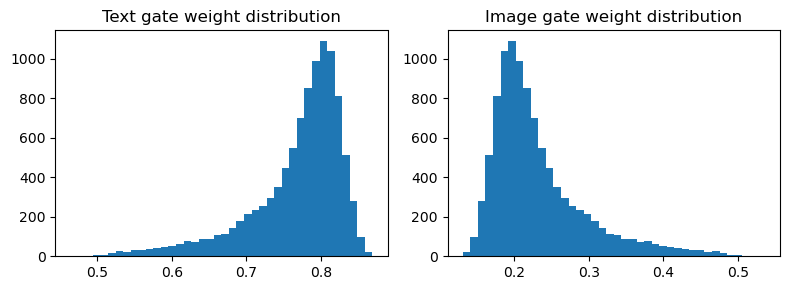

: 

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import requests
from io import BytesIO

# ===============================
# CONFIG
# ===============================
DATA_FILE = "amazon_fashion_trimmed_10000.csv"
TEXT_EMB_CACHE = "text_embeddings.pt"
IMAGE_EMB_CACHE = "image_embeddings.pt"
FUSION_CHECKPOINT = "fusion_checkpoint_cross_modal.pt"
MODEL_NAME = "clip-ViT-B-32"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float32

# Training hyperparams
EPOCHS = 5
BATCH_SIZE = 512
LR = 1e-4
WEIGHT_DECAY = 1e-6
TEMPERATURE = 0.07
PRINT_EVERY = 50
SAVE_EVERY = 1  # epochs

# ===============================
# Load dataset
# ===============================
df = pd.read_csv(DATA_FILE)

# ===============================
# Load CLIP model
# ===============================
model = SentenceTransformer(MODEL_NAME, device=DEVICE)

# ===============================
# Load cached text embeddings
# ===============================
if os.path.exists(TEXT_EMB_CACHE):
    print("Loading cached text embeddings...")
    text_embeddings = torch.load(TEXT_EMB_CACHE, map_location=DEVICE)
else:
    print("Generating text embeddings...")
    text_embeddings = model.encode(
        df["title"].tolist(),
        convert_to_tensor=True,
        show_progress_bar=True
    )
    torch.save(text_embeddings, TEXT_EMB_CACHE)

text_embeddings = text_embeddings.to(device=DEVICE, dtype=DTYPE)

# ===============================
# Load cached image embeddings
# ===============================
if not os.path.exists(IMAGE_EMB_CACHE):
    raise FileNotFoundError(f"{IMAGE_EMB_CACHE} not found! Please generate and save it first.")

print("Loading cached image embeddings...")
img_cache = torch.load(IMAGE_EMB_CACHE, map_location=DEVICE)

if isinstance(img_cache, dict):
    missing = [u for u in df["image_large"] if u not in img_cache]
    if missing:
        print(f"[WARN] {len(missing)} urls from CSV not found in cache. They will be zeroed.")
    image_embeddings_list = []
    some_vec = None
    for v in img_cache.values():
        if isinstance(v, torch.Tensor) and v.numel() > 0:
            some_vec = v
            break
    if some_vec is None:
        raise ValueError("Image embedding cache is empty or invalid.")
    emb_dim = some_vec.shape[-1]
    for url in df["image_large"]:
        if url in img_cache and isinstance(img_cache[url], torch.Tensor) and img_cache[url].numel() == emb_dim:
            image_embeddings_list.append(img_cache[url].to(device=DEVICE, dtype=DTYPE))
        else:
            image_embeddings_list.append(torch.zeros(emb_dim, device=DEVICE, dtype=DTYPE))
    image_embeddings = torch.stack(image_embeddings_list)
else:
    image_embeddings = img_cache.to(device=DEVICE, dtype=DTYPE)

# ===============================
# Optional: L2 normalization
# ===============================
def l2_normalize(x, eps=1e-12):
    return x / (x.norm(p=2, dim=1, keepdim=True).clamp_min(eps))

# ===============================
# Hierarchical Attention Module
# ===============================
class HierarchicalAttentionFusion(nn.Module):
    def __init__(self, embed_dim, hidden_dim=128):
        super().__init__()
        self.text_att = nn.Linear(embed_dim, 1)
        self.image_att = nn.Linear(embed_dim, 1)
        self.fusion_att = nn.Sequential(
            nn.Linear(embed_dim*2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, text_emb, image_emb):
        text_w = torch.sigmoid(self.text_att(text_emb))
        img_w = torch.sigmoid(self.image_att(image_emb))
        text_rep = text_w * text_emb
        img_rep = img_w * image_emb

        fusion_input = torch.cat([text_rep, img_rep], dim=-1)
        fusion_logits = self.fusion_att(fusion_input)
        fusion_weights = F.softmax(fusion_logits, dim=-1)
        fused = fusion_weights[:, 0].unsqueeze(1) * text_rep + \
                fusion_weights[:, 1].unsqueeze(1) * img_rep
        fused = F.normalize(fused, p=2, dim=1)
        return fused, fusion_weights

# ===============================
# Instantiate fusion model
# ===============================
fusion_model = HierarchicalAttentionFusion(embed_dim=text_embeddings.shape[1]).to(DEVICE)

# Resume checkpoint if exists
start_epoch = 0
if os.path.exists(FUSION_CHECKPOINT):
    try:
        ckpt = torch.load(FUSION_CHECKPOINT, map_location=DEVICE)
        fusion_model.load_state_dict(ckpt["model_state"])
        start_epoch = ckpt.get("epoch", 0) + 1
        print(f"[INFO] Loaded fusion checkpoint from epoch {ckpt.get('epoch', 'unknown')}")
    except Exception as e:
        print(f"[WARN] Failed to load checkpoint: {e}")

# ===============================
# Training utilities
# ===============================
optimizer = torch.optim.AdamW(fusion_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

def train_cross_modal(text_embs, image_embs, model, epochs=EPOCHS, batch_size=BATCH_SIZE, device=DEVICE, temp=TEMPERATURE):
    n = text_embs.shape[0]
    model.train()
    for epoch in range(start_epoch, start_epoch + epochs):
        perm = torch.randperm(n, device=device)
        running_loss = 0.0
        it = 0
        for s in range(0, n, batch_size):
            e = min(s+batch_size, n)
            idxs = perm[s:e]
            t_b = text_embs[idxs]
            i_b = image_embs[idxs]

            fused_b, _ = model(t_b, i_b)
            fused_b = F.normalize(fused_b, p=2, dim=1)
            t_b_n = F.normalize(t_b, p=2, dim=1)
            i_b_n = F.normalize(i_b, p=2, dim=1)

            # Cross-modal logits
            logits_ft = (fused_b @ t_b_n.T) / temp  # fused→text
            logits_fi = (fused_b @ i_b_n.T) / temp  # fused→image
            logits_tf = (t_b_n @ i_b_n.T) / temp    # text→image
            logits_it = (i_b_n @ t_b_n.T) / temp    # image→text

            labels = torch.arange(logits_ft.size(0), device=device)
            loss = F.cross_entropy(logits_ft, labels) + F.cross_entropy(logits_fi, labels) + \
                   F.cross_entropy(logits_tf, labels) + F.cross_entropy(logits_it, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            it += 1
            if it % PRINT_EVERY == 0:
                print(f"Epoch {epoch} | iter {it} | avg loss: {running_loss/it:.4f}")

        scheduler.step()
        print(f"Epoch {epoch} completed. Avg loss: {running_loss/max(1,it):.4f}")

        if (epoch+1) % SAVE_EVERY == 0:
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }, FUSION_CHECKPOINT)
            print(f"[INFO] Checkpoint saved at epoch {epoch}")

# ===============================
# Evaluation helpers
# ===============================
def recall_mrr_text_to_image(text_embs, image_embs, top_k_list=[1,5,10], batch_size=512):
    text_embs = l2_normalize(text_embs)
    image_embs = l2_normalize(image_embs)
    n = text_embs.shape[0]
    recalls = {k:0 for k in top_k_list}
    mrr_total = 0.0
    for start in range(0, n, batch_size):
        end = min(start+batch_size, n)
        q = text_embs[start:end]
        scores = q @ image_embs.T
        for b in range(scores.size(0)):
            correct = start+b
            vals, idxs = torch.topk(scores[b], k=max(top_k_list))
            idxs = idxs.tolist()
            found_rank = None
            for rank, j in enumerate(idxs, start=1):
                if j==correct:
                    found_rank=rank
                    break
            if found_rank is not None:
                for k in top_k_list:
                    if found_rank<=k: recalls[k]+=1
                mrr_total+=1.0/found_rank
    results = {f"Recall@{k}": recalls[k]/n for k in top_k_list}
    results["MRR"] = mrr_total/n
    return results

def recall_mrr_fused(fused_embs, top_k_list=[1,5,10], batch_size=512):
    fused_embs = l2_normalize(fused_embs)
    n = fused_embs.shape[0]
    recalls = {k:0 for k in top_k_list}
    mrr_total = 0.0
    for start in range(0, n, batch_size):
        end = min(start+batch_size, n)
        q = fused_embs[start:end]
        scores = q @ fused_embs.T
        for b in range(scores.size(0)):
            correct = start+b
            vals, idxs = torch.topk(scores[b], k=max(top_k_list))
            idxs = idxs.tolist()
            found_rank=None
            for rank,j in enumerate(idxs,start=1):
                if j==correct:
                    found_rank=rank
                    break
            if found_rank is not None:
                for k in top_k_list:
                    if found_rank<=k: recalls[k]+=1
                mrr_total+=1.0/found_rank
    results = {f"Recall@{k}": recalls[k]/n for k in top_k_list}
    results["MRR"]=mrr_total/n
    return results

# ===============================
# Run baseline evaluations
# ===============================
fusion_model.eval()
with torch.no_grad():
    fused_embeddings_init, fusion_weights_init = fusion_model(text_embeddings, image_embeddings)
print("Initial fused embeddings shape:", fused_embeddings_init.shape)

print("\nProxy Evaluation BEFORE training:")
metrics_t2i_before = recall_mrr_text_to_image(text_embeddings, image_embeddings)
metrics_i2t_before = recall_mrr_text_to_image(image_embeddings, text_embeddings)
for k,v in metrics_t2i_before.items(): print(f"Text → Image {k}: {v:.4f}")
for k,v in metrics_i2t_before.items(): print(f"Image → Text {k}: {v:.4f}")

metrics_fused_before = recall_mrr_fused(fused_embeddings_init)
print("\nFused→Fused self-retrieval BEFORE training:")
for k,v in metrics_fused_before.items(): print(f"Fused {k}: {v:.4f}")

# ===============================
# Train cross-modal fusion
# ===============================
print("\nStarting fusion training (cross-modal InfoNCE)...")
train_cross_modal(text_embeddings, image_embeddings, fusion_model)

# ===============================
# Evaluate after training
# ===============================
fusion_model.eval()
with torch.no_grad():
    fused_embeddings, fusion_weights = fusion_model(text_embeddings, image_embeddings)

print("\nProxy Evaluation AFTER training:")
metrics_t2i_after = recall_mrr_text_to_image(text_embeddings, image_embeddings)
metrics_i2t_after = recall_mrr_text_to_image(image_embeddings, text_embeddings)
for k,v in metrics_t2i_after.items(): print(f"Text → Image {k}: {v:.4f}")
for k,v in metrics_i2t_after.items(): print(f"Image → Text {k}: {v:.4f}")

metrics_fused_after = recall_mrr_fused(fused_embeddings)
print("\nFused→Fused self-retrieval AFTER training:")
for k,v in metrics_fused_after.items(): print(f"Fused {k}: {v:.4f}")

# ===============================
# Save fused embeddings & weights
# ===============================
torch.save({
    "fused_embeddings": fused_embeddings.cpu(),
    "fusion_weights": fusion_weights.cpu()
}, "fused_embeddings_and_weights.pt")
print("[INFO] Saved fused embeddings and fusion weights to fused_embeddings_and_weights.pt")

# Optional: fusion weights histogram
try:
    import matplotlib.pyplot as plt
    fw = fusion_weights.cpu().numpy()
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1); plt.hist(fw[:,0], bins=40); plt.title("Text gate weight distribution")
    plt.subplot(1,2,2); plt.hist(fw[:,1], bins=40); plt.title("Image gate weight distribution")
    plt.tight_layout(); plt.savefig("fusion_weights_hist.png")
    print("[INFO] Saved fusion_weights_hist.png")
except Exception as e:
    print(f"[WARN] Could not produce diagnostic plot: {e}")

# ===============================
# Recommendation function
# ===============================
def recommend(idx, top_k=5):
    query_emb = fused_embeddings[idx]
    scores = util.cos_sim(query_emb, fused_embeddings)[0]
    top_results = torch.topk(scores, k=top_k+1)

    print(f"\nQuery: {df.iloc[idx]['title']}")
    try:
        img = Image.open(BytesIO(requests.get(df.iloc[idx]['image_large']).content)).convert("RGB")
        display(img)
    except:
        print("[Image not available]")

    print("\nTop Recommendations:")
    for score, i in zip(top_results[0][1:], top_results[1][1:]):
        i = int(i)
        print(f"{df.iloc[i]['title']} (score: {score.item():.4f}) | Weights (T:{fusion_weights[i,0]:.2f}, I:{fusion_weights[i,1]:.2f})")
        try:
            img = Image.open(BytesIO(requests.get(df.iloc[i]['image_large']).content)).convert("RGB")
            display(img)
        except:
            print("[Image not available]")

# Example usage:
# recommend(0, top_k=5)


In [25]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split

# ===============================
# CONFIG
# ===============================
DATA_FILE = "amazon_fashion_trimmed_10000.csv"
TEXT_EMB_CACHE = "text_embeddings.pt"
IMAGE_EMB_CACHE = "image_embeddings.pt"
FUSION_CHECKPOINT = "fusion_checkpoint_cross_modal.pt"
MODEL_NAME = "clip-ViT-B-32"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float32

# Training hyperparams
EPOCHS = 5
BATCH_SIZE = 512
LR = 1e-4
WEIGHT_DECAY = 1e-6
TEMPERATURE = 0.07
PRINT_EVERY = 50
SAVE_EVERY = 1  # epochs
GRAD_CLIP = 1.0  # Gradient clipping
VALIDATION_SPLIT = 0.2  # Fraction of data to use for validation

# ===============================
# Load dataset
# ===============================
df = pd.read_csv(DATA_FILE)

# Create train/validation split
train_indices, val_indices = train_test_split(
    range(len(df)), 
    test_size=VALIDATION_SPLIT, 
    random_state=42
)
train_indices = torch.tensor(train_indices, device=DEVICE)
val_indices = torch.tensor(val_indices, device=DEVICE)

print(f"Training samples: {len(train_indices)}, Validation samples: {len(val_indices)}")

# ===============================
# Load CLIP model
# ===============================
model = SentenceTransformer(MODEL_NAME, device=DEVICE)

# ===============================
# Load cached text embeddings
# ===============================
if os.path.exists(TEXT_EMB_CACHE):
    print("Loading cached text embeddings...")
    text_embeddings = torch.load(TEXT_EMB_CACHE, map_location=DEVICE)
else:
    print("Generating text embeddings...")
    text_embeddings = model.encode(
        df["title"].tolist(),
        convert_to_tensor=True,
        show_progress_bar=True
    )
    torch.save(text_embeddings, TEXT_EMB_CACHE)

text_embeddings = text_embeddings.to(device=DEVICE, dtype=DTYPE)

# ===============================
# Load cached image embeddings
# ===============================
if not os.path.exists(IMAGE_EMB_CACHE):
    raise FileNotFoundError(f"{IMAGE_EMB_CACHE} not found! Please generate and save it first.")

print("Loading cached image embeddings...")
img_cache = torch.load(IMAGE_EMB_CACHE, map_location=DEVICE)

if isinstance(img_cache, dict):
    missing = [u for u in df["image_large"] if u not in img_cache]
    if missing:
        print(f"[WARN] {len(missing)} urls from CSV not found in cache. They will be zeroed.")
    
    # Find a valid embedding to determine dimension
    some_vec = None
    for v in img_cache.values():
        if isinstance(v, torch.Tensor) and v.numel() > 0:
            some_vec = v
            break
    if some_vec is None:
        raise ValueError("Image embedding cache is empty or invalid.")
    
    emb_dim = some_vec.shape[-1]
    image_embeddings_list = []
    valid_count = 0
    zero_count = 0
    
    for url in df["image_large"]:
        if url in img_cache and isinstance(img_cache[url], torch.Tensor):
            if torch.any(torch.isnan(img_cache[url])) or torch.any(torch.isinf(img_cache[url])):
                image_embeddings_list.append(torch.zeros(emb_dim, device=DEVICE, dtype=DTYPE))
                zero_count += 1
            else:
                image_embeddings_list.append(img_cache[url].to(device=DEVICE, dtype=DTYPE))
                valid_count += 1
        else:
            image_embeddings_list.append(torch.zeros(emb_dim, device=DEVICE, dtype=DTYPE))
            zero_count += 1
            
    image_embeddings = torch.stack(image_embeddings_list)
    print(f"Image embeddings: {valid_count} valid, {zero_count} zeroed")
else:
    image_embeddings = img_cache.to(device=DEVICE, dtype=DTYPE)

# ===============================
# Optional: L2 normalization
# ===============================
def l2_normalize(x, eps=1e-12):
    return x / (x.norm(p=2, dim=1, keepdim=True).clamp_min(eps))

# ===============================
# Hierarchical Attention Module
# ===============================
class HierarchicalAttentionFusion(nn.Module):
    def __init__(self, embed_dim, hidden_dim=128):
        super().__init__()
        self.text_att = nn.Linear(embed_dim, 1)
        self.image_att = nn.Linear(embed_dim, 1)
        self.fusion_att = nn.Sequential(
            nn.Linear(embed_dim*2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, text_emb, image_emb):
        text_w = torch.sigmoid(self.text_att(text_emb))
        img_w = torch.sigmoid(self.image_att(image_emb))
        text_rep = text_w * text_emb
        img_rep = img_w * image_emb

        fusion_input = torch.cat([text_rep, img_rep], dim=-1)
        fusion_logits = self.fusion_att(fusion_input)
        fusion_weights = F.softmax(fusion_logits, dim=-1)
        fused = fusion_weights[:, 0].unsqueeze(1) * text_rep + \
                fusion_weights[:, 1].unsqueeze(1) * img_rep
        fused = F.normalize(fused, p=2, dim=1)
        return fused, fusion_weights

# ===============================
# Instantiate fusion model
# ===============================
fusion_model = HierarchicalAttentionFusion(embed_dim=text_embeddings.shape[1]).to(DEVICE)

# Resume checkpoint if exists
start_epoch = 0
if os.path.exists(FUSION_CHECKPOINT):
    try:
        ckpt = torch.load(FUSION_CHECKPOINT, map_location=DEVICE)
        fusion_model.load_state_dict(ckpt["model_state"])
        start_epoch = ckpt.get("epoch", 0) + 1
        print(f"[INFO] Loaded fusion checkpoint from epoch {ckpt.get('epoch', 'unknown')}")
    except Exception as e:
        print(f"[WARN] Failed to load checkpoint: {e}")

# ===============================
# Training utilities
# ===============================
optimizer = torch.optim.AdamW(fusion_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

def train_cross_modal(text_embs, image_embs, train_indices, val_indices, model, epochs=EPOCHS, 
                     batch_size=BATCH_SIZE, device=DEVICE, temp=TEMPERATURE):
    n = len(train_indices)
    model.train()
    
    # For tracking best validation performance
    best_val_mrr = 0
    best_epoch = 0
    
    for epoch in range(start_epoch, start_epoch + epochs):
        perm = torch.randperm(n, device=device)
        running_loss = 0.0
        it = 0
        start_time = time.time()
        
        for s in range(0, n, batch_size):
            e = min(s+batch_size, n)
            idxs = train_indices[perm[s:e]]
            t_b = text_embs[idxs]
            i_b = image_embs[idxs]

            fused_b, _ = model(t_b, i_b)
            fused_b = F.normalize(fused_b, p=2, dim=1)
            t_b_n = F.normalize(t_b, p=2, dim=1)
            i_b_n = F.normalize(i_b, p=2, dim=1)

            # Cross-modal logits
            logits_ft = (fused_b @ t_b_n.T) / temp  # fused→text
            logits_fi = (fused_b @ i_b_n.T) / temp  # fused→image
            logits_tf = (t_b_n @ i_b_n.T) / temp    # text→image
            logits_it = (i_b_n @ t_b_n.T) / temp    # image→text

            labels = torch.arange(logits_ft.size(0), device=device)
            loss = F.cross_entropy(logits_ft, labels) + F.cross_entropy(logits_fi, labels) + \
                   F.cross_entropy(logits_tf, labels) + F.cross_entropy(logits_it, labels)

            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            
            optimizer.step()

            running_loss += loss.item()
            it += 1
            if it % PRINT_EVERY == 0:
                current_lr = scheduler.get_last_lr()[0]
                print(f"Epoch {epoch} | iter {it} | lr: {current_lr:.2e} | avg loss: {running_loss/it:.4f}")

        scheduler.step()
        epoch_time = time.time() - start_time
        
        # Validation
        val_metrics = evaluate_on_split(model, text_embs, image_embs, val_indices)
        print(f"Epoch {epoch} completed in {epoch_time:.2f}s. Avg loss: {running_loss/max(1,it):.4f}")
        print(f"Validation - MRR: {val_metrics['MRR']:.4f}, R@1: {val_metrics['Recall@1']:.4f}, R@5: {val_metrics['Recall@5']:.4f}")
        
        # Save best model
        if val_metrics['MRR'] > best_val_mrr:
            best_val_mrr = val_metrics['MRR']
            best_epoch = epoch
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_mrr": best_val_mrr
            }, "best_fusion_model.pt")
            print(f"[INFO] New best model saved with MRR: {best_val_mrr:.4f}")

        if (epoch+1) % SAVE_EVERY == 0:
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_mrr": val_metrics['MRR']
            }, FUSION_CHECKPOINT)
            print(f"[INFO] Checkpoint saved at epoch {epoch}")

    print(f"Training completed. Best validation MRR: {best_val_mrr:.4f} at epoch {best_epoch}")

def evaluate_on_split(model, text_embs, image_embs, indices, top_k_list=[1,5,10], batch_size=512):
    model.eval()
    with torch.no_grad():
        fused_embs, _ = model(text_embs[indices], image_embs[indices])
        metrics = recall_mrr_fused(fused_embs, top_k_list, batch_size)
    model.train()
    return metrics

# ===============================
# Evaluation helpers
# ===============================
def recall_mrr_text_to_image(text_embs, image_embs, top_k_list=[1,5,10], batch_size=512):
    text_embs = l2_normalize(text_embs)
    image_embs = l2_normalize(image_embs)
    n = text_embs.shape[0]
    recalls = {k:0 for k in top_k_list}
    mrr_total = 0.0
    
    # Use FAISS for faster computation if available
    try:
        import faiss
        use_faiss = True
        # Convert to numpy for FAISS
        image_embs_np = image_embs.cpu().numpy().astype('float32')
        # Create FAISS index
        index = faiss.IndexFlatIP(image_embs_np.shape[1])
        index.add(image_embs_np)
        print("Using FAISS for accelerated similarity search")
    except ImportError:
        use_faiss = False
        print("FAISS not available, using exact computation")
    
    for start in range(0, n, batch_size):
        end = min(start+batch_size, n)
        q = text_embs[start:end]
        
        if use_faiss:
            q_np = q.cpu().numpy().astype('float32')
            scores, idxs = index.search(q_np, k=max(top_k_list))
            idxs = torch.from_numpy(idxs).to(text_embs.device)
        else:
            scores = q @ image_embs.T
            vals, idxs = torch.topk(scores, k=max(top_k_list), dim=1)
        
        for b in range(scores.shape[0]):
            correct = start + b
            found_rank = None
            
            for rank, j in enumerate(idxs[b], start=1):
                if j == correct:
                    found_rank = rank
                    break
                    
            if found_rank is not None:
                for k in top_k_list:
                    if found_rank <= k: 
                        recalls[k] += 1
                mrr_total += 1.0 / found_rank
                
    results = {f"Recall@{k}": recalls[k]/n for k in top_k_list}
    results["MRR"] = mrr_total/n
    return results

def recall_mrr_fused(fused_embs, top_k_list=[1,5,10], batch_size=512):
    fused_embs = l2_normalize(fused_embs)
    n = fused_embs.shape[0]
    recalls = {k:0 for k in top_k_list}
    mrr_total = 0.0
    
    # Use FAISS for faster computation if available
    try:
        import faiss
        use_faiss = True
        # Convert to numpy for FAISS
        fused_embs_np = fused_embs.cpu().numpy().astype('float32')
        # Create FAISS index
        index = faiss.IndexFlatIP(fused_embs_np.shape[1])
        index.add(fused_embs_np)
        print("Using FAISS for accelerated similarity search")
    except ImportError:
        use_faiss = False
        print("FAISS not available, using exact computation")
    
    for start in range(0, n, batch_size):
        end = min(start+batch_size, n)
        q = fused_embs[start:end]
        
        if use_faiss:
            q_np = q.cpu().numpy().astype('float32')
            scores, idxs = index.search(q_np, k=max(top_k_list))
            idxs = torch.from_numpy(idxs).to(fused_embs.device)
        else:
            scores = q @ fused_embs.T
            vals, idxs = torch.topk(scores, k=max(top_k_list), dim=1)
        
        for b in range(scores.shape[0]):
            correct = start + b
            found_rank = None
            
            for rank, j in enumerate(idxs[b], start=1):
                if j == correct:
                    found_rank = rank
                    break
                    
            if found_rank is not None:
                for k in top_k_list:
                    if found_rank <= k: 
                        recalls[k] += 1
                mrr_total += 1.0 / found_rank
                
    results = {f"Recall@{k}": recalls[k]/n for k in top_k_list}
    results["MRR"] = mrr_total/n
    return results

# ===============================
# Run baseline evaluations
# ===============================
fusion_model.eval()
with torch.no_grad():
    fused_embeddings_init, fusion_weights_init = fusion_model(text_embeddings, image_embeddings)
print("Initial fused embeddings shape:", fused_embeddings_init.shape)

print("\nProxy Evaluation BEFORE training:")
metrics_t2i_before = recall_mrr_text_to_image(text_embeddings, image_embeddings)
metrics_i2t_before = recall_mrr_text_to_image(image_embeddings, text_embeddings)
for k,v in metrics_t2i_before.items(): print(f"Text → Image {k}: {v:.4f}")
for k,v in metrics_i2t_before.items(): print(f"Image → Text {k}: {v:.4f}")

metrics_fused_before = recall_mrr_fused(fused_embeddings_init)
print("\nFused→Fused self-retrieval BEFORE training:")
for k,v in metrics_fused_before.items(): print(f"Fused {k}: {v:.4f}")

# ===============================
# Train cross-modal fusion
# ===============================
print("\nStarting fusion training (cross-modal InfoNCE)...")
train_cross_modal(text_embeddings, image_embeddings, train_indices, val_indices, fusion_model)

# Load best model
if os.path.exists("best_fusion_model.pt"):
    ckpt = torch.load("best_fusion_model.pt", map_location=DEVICE)
    fusion_model.load_state_dict(ckpt["model_state"])
    print(f"Loaded best model from epoch {ckpt['epoch']} with validation MRR: {ckpt['val_mrr']:.4f}")

# ===============================
# Evaluate after training
# ===============================
fusion_model.eval()
with torch.no_grad():
    fused_embeddings, fusion_weights = fusion_model(text_embeddings, image_embeddings)

print("\nProxy Evaluation AFTER training:")
metrics_t2i_after = recall_mrr_text_to_image(text_embeddings, image_embeddings)
metrics_i2t_after = recall_mrr_text_to_image(image_embeddings, text_embeddings)
for k,v in metrics_t2i_after.items(): print(f"Text → Image {k}: {v:.4f}")
for k,v in metrics_i2t_after.items(): print(f"Image → Text {k}: {v:.4f}")

metrics_fused_after = recall_mrr_fused(fused_embeddings)
print("\nFused→Fused self-retrieval AFTER training:")
for k,v in metrics_fused_after.items(): print(f"Fused {k}: {v:.4f}")

# ===============================
# Enhanced diagnostic plots
# ===============================
def plot_training_diagnostics(fusion_weights, metrics_before, metrics_after):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Fusion weights
    axes[0, 0].hist(fusion_weights[:, 0].cpu().numpy(), bins=40, alpha=0.7, label='Text')
    axes[0, 0].hist(fusion_weights[:, 1].cpu().numpy(), bins=40, alpha=0.7, label='Image')
    axes[0, 0].set_title("Fusion Weight Distribution")
    axes[0, 0].legend()
    
    # Metrics comparison
    metrics = ['Recall@1', 'Recall@5', 'Recall@10', 'MRR']
    before_vals = [metrics_before[m] for m in metrics]
    after_vals = [metrics_after[m] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    axes[0, 1].bar(x - width/2, before_vals, width, label='Before')
    axes[0, 1].bar(x + width/2, after_vals, width, label='After')
    axes[0, 1].set_title('Performance Comparison')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(metrics)
    axes[0, 1].legend()
    
    # Correlation between modalities
    text_norm = F.normalize(text_embeddings, p=2, dim=1)
    image_norm = F.normalize(image_embeddings, p=2, dim=1)
    modality_similarity = (text_norm * image_norm).sum(dim=1)
    axes[1, 0].hist(modality_similarity.cpu().numpy(), bins=40)
    axes[1, 0].set_title('Text-Image Similarity Distribution')
    
    # Weight vs similarity correlation
    axes[1, 1].scatter(modality_similarity.cpu().numpy(), fusion_weights[:, 0].cpu().numpy(), alpha=0.5)
    axes[1, 1].set_xlabel('Text-Image Similarity')
    axes[1, 1].set_ylabel('Text Fusion Weight')
    axes[1, 1].set_title('Weight vs Modality Alignment')
    
    plt.tight_layout()
    plt.savefig("comprehensive_diagnostics.png")
    plt.close()
    print("[INFO] Saved comprehensive_diagnostics.png")

# Generate diagnostic plots
plot_training_diagnostics(fusion_weights, metrics_fused_before, metrics_fused_after)

# ===============================
# Save fused embeddings & weights
# ===============================
torch.save({
    "fused_embeddings": fused_embeddings.cpu(),
    "fusion_weights": fusion_weights.cpu(),
    "text_embeddings": text_embeddings.cpu(),
    "image_embeddings": image_embeddings.cpu()
}, "fused_embeddings_and_weights.pt")
print("[INFO] Saved fused embeddings and fusion weights to fused_embeddings_and_weights.pt")

# ===============================
# Enhanced Recommendation function
# ===============================
def recommend(idx, top_k=5, show_images=True):
    if idx >= len(fused_embeddings):
        print(f"Index {idx} out of bounds. Maximum index is {len(fused_embeddings)-1}")
        return
        
    query_emb = fused_embeddings[idx]
    scores = util.cos_sim(query_emb, fused_embeddings)[0]
    
    # Exclude self
    mask = torch.ones(len(scores), dtype=torch.bool)
    mask[idx] = False
    filtered_scores = scores[mask]
    filtered_indices = torch.arange(len(scores), device=scores.device)[mask]
    
    top_results = torch.topk(filtered_scores, k=top_k)
    
    print(f"\nQuery: {df.iloc[idx]['title']}")
    if show_images:
        try:
            response = requests.get(df.iloc[idx]['image_large'], timeout=5)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"[Query image not available: {e}]")
    
    print("\nTop Recommendations:")
    for i, (score, idx_val) in enumerate(zip(top_results[0], top_results[1])):
        rec_idx = int(filtered_indices[idx_val])
        print(f"{i+1}. {df.iloc[rec_idx]['title']} (score: {score.item():.4f})")
        print(f"   Fusion weights (Text: {fusion_weights[rec_idx, 0]:.3f}, Image: {fusion_weights[rec_idx, 1]:.3f})")
        
        if show_images:
            try:
                response = requests.get(df.iloc[rec_idx]['image_large'], timeout=5)
                img = Image.open(BytesIO(response.content)).convert("RGB")
                plt.imshow(img)
                plt.axis('off')
                plt.show()
            except Exception as e:
                print(f"   [Image not available: {e}]")
        print()

# Example usage:
# recommend(0, top_k=5)

Training samples: 8000, Validation samples: 2000
Loading cached text embeddings...
Loading cached image embeddings...
Image embeddings: 10000 valid, 0 zeroed
[INFO] Loaded fusion checkpoint from epoch 4
Initial fused embeddings shape: torch.Size([10000, 512])

Proxy Evaluation BEFORE training:
FAISS not available, using exact computation
FAISS not available, using exact computation
Text → Image Recall@1: 0.0628
Text → Image Recall@5: 0.1494
Text → Image Recall@10: 0.2127
Text → Image MRR: 0.1016
Image → Text Recall@1: 0.0882
Image → Text Recall@5: 0.2162
Image → Text Recall@10: 0.2965
Image → Text MRR: 0.1440
FAISS not available, using exact computation

Fused→Fused self-retrieval BEFORE training:
Fused Recall@1: 0.9941
Fused Recall@5: 1.0000
Fused Recall@10: 1.0000
Fused MRR: 0.9970

Starting fusion training (cross-modal InfoNCE)...
FAISS not available, using exact computation
Epoch 5 completed in 0.42s. Avg loss: 15.4535
Validation - MRR: 0.9992, R@1: 0.9985, R@5: 1.0000
[INFO] New b

In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
import argparse

# ===============================
# CONFIG
# ===============================
DATA_FILE = "amazon_fashion_trimmed_10000.csv"
TEXT_EMB_CACHE = "text_embeddings.pt"
IMAGE_EMB_CACHE = "image_embeddings.pt"
FUSION_CHECKPOINT = "fusion_checkpoint_cross_modal.pt"
MODEL_NAME = "clip-ViT-B-32"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float32

# Training hyperparams
EPOCHS = 20
BATCH_SIZE = 256
LR = 1e-4
WEIGHT_DECAY = 1e-6
TEMPERATURE = 0.07
PRINT_EVERY = 50
SAVE_EVERY = 5  # epochs
GRAD_CLIP = 1.0  # Gradient clipping
VALIDATION_SPLIT = 0.2  # Fraction of data to use for validation

# ===============================
# Load dataset
# ===============================
df = pd.read_csv(DATA_FILE)
print(f"Dataset loaded with {len(df)} samples")

# Create train/validation split
train_indices, val_indices = train_test_split(
    range(len(df)), 
    test_size=VALIDATION_SPLIT, 
    random_state=42
)
train_indices = torch.tensor(train_indices, device=DEVICE)
val_indices = torch.tensor(val_indices, device=DEVICE)

print(f"Training samples: {len(train_indices)}, Validation samples: {len(val_indices)}")

# ===============================
# Load CLIP model
# ===============================
model = SentenceTransformer(MODEL_NAME, device=DEVICE)

# ===============================
# Load cached text embeddings
# ===============================
if os.path.exists(TEXT_EMB_CACHE):
    print("Loading cached text embeddings...")
    text_embeddings = torch.load(TEXT_EMB_CACHE, map_location=DEVICE)
else:
    print("Generating text embeddings...")
    text_embeddings = model.encode(
        df["title"].tolist(),
        convert_to_tensor=True,
        show_progress_bar=True
    )
    torch.save(text_embeddings, TEXT_EMB_CACHE)

text_embeddings = text_embeddings.to(device=DEVICE, dtype=DTYPE)

# ===============================
# Load cached image embeddings
# ===============================
if not os.path.exists(IMAGE_EMB_CACHE):
    raise FileNotFoundError(f"{IMAGE_EMB_CACHE} not found! Please generate and save it first.")

print("Loading cached image embeddings...")
img_cache = torch.load(IMAGE_EMB_CACHE, map_location=DEVICE)

if isinstance(img_cache, dict):
    missing = [u for u in df["image_large"] if u not in img_cache]
    if missing:
        print(f"[WARN] {len(missing)} urls from CSV not found in cache. They will be zeroed.")
    
    # Find a valid embedding to determine dimension
    some_vec = None
    for v in img_cache.values():
        if isinstance(v, torch.Tensor) and v.numel() > 0:
            some_vec = v
            break
    if some_vec is None:
        raise ValueError("Image embedding cache is empty or invalid.")
    
    emb_dim = some_vec.shape[-1]
    image_embeddings_list = []
    valid_count = 0
    zero_count = 0
    
    for url in df["image_large"]:
        if url in img_cache and isinstance(img_cache[url], torch.Tensor):
            if torch.any(torch.isnan(img_cache[url])) or torch.any(torch.isinf(img_cache[url])):
                image_embeddings_list.append(torch.zeros(emb_dim, device=DEVICE, dtype=DTYPE))
                zero_count += 1
            else:
                image_embeddings_list.append(img_cache[url].to(device=DEVICE, dtype=DTYPE))
                valid_count += 1
        else:
            image_embeddings_list.append(torch.zeros(emb_dim, device=DEVICE, dtype=DTYPE))
            zero_count += 1
            
    image_embeddings = torch.stack(image_embeddings_list)
    print(f"Image embeddings: {valid_count} valid, {zero_count} zeroed")
else:
    image_embeddings = img_cache.to(device=DEVICE, dtype=DTYPE)

# Normalize embeddings
text_embeddings = F.normalize(text_embeddings, p=2, dim=1)
image_embeddings = F.normalize(image_embeddings, p=2, dim=1)

# ===============================
# Enhanced Fusion Module
# ===============================
class CrossModalFusion(nn.Module):
    def __init__(self, embed_dim, hidden_dim=512, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        
        # Cross-attention layers
        self.text_attention = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.Tanh(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )
        
        self.image_attention = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.Tanh(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )
        
        # Fusion gate
        self.fusion_gate = nn.Sequential(
            nn.Linear(embed_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2),
            nn.Softmax(dim=-1)
        )
        
        # Projection layer
        self.projection = nn.Sequential(
            nn.Linear(embed_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim)
        )

    def forward(self, text_emb, image_emb):
        # Calculate attention weights
        text_attn = torch.sigmoid(self.text_attention(text_emb))
        image_attn = torch.sigmoid(self.image_attention(image_emb))
        
        # Apply attention
        text_attended = text_attn * text_emb
        image_attended = image_attn * image_emb
        
        # Calculate fusion weights
        fusion_input = torch.cat([text_attended, image_attended], dim=-1)
        fusion_weights = self.fusion_gate(fusion_input)
        
        # Fuse modalities
        fused = fusion_weights[:, 0:1] * text_attended + fusion_weights[:, 1:2] * image_attended
        
        # Project to common space
        projected = self.projection(torch.cat([text_attended, image_attended], dim=-1))
        
        # Combine with residual connection
        output = fused + projected
        output = F.normalize(output, p=2, dim=1)
        
        return output, fusion_weights

# ===============================
# Instantiate fusion model
# ===============================
fusion_model = CrossModalFusion(embed_dim=text_embeddings.shape[1]).to(DEVICE)
print(f"Fusion model parameters: {sum(p.numel() for p in fusion_model.parameters()):,}")

# Resume checkpoint if exists
start_epoch = 0
if os.path.exists(FUSION_CHECKPOINT):
    try:
        ckpt = torch.load(FUSION_CHECKPOINT, map_location=DEVICE)
        fusion_model.load_state_dict(ckpt["model_state"])
        start_epoch = ckpt.get("epoch", 0) + 1
        print(f"[INFO] Loaded fusion checkpoint from epoch {ckpt.get('epoch', 'unknown')}")
    except Exception as e:
        print(f"[WARN] Failed to load checkpoint: {e}")

# ===============================
# Training utilities
# ===============================
optimizer = torch.optim.AdamW(fusion_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Enhanced loss function with contrastive learning
def contrastive_loss(fused, text, image, temperature=TEMPERATURE):
    # Normalize all embeddings
    fused = F.normalize(fused, p=2, dim=1)
    text = F.normalize(text, p=2, dim=1)
    image = F.normalize(image, p=2, dim=1)
    
    # Calculate similarities
    sim_ft = torch.matmul(fused, text.T) / temperature  # fused to text
    sim_fi = torch.matmul(fused, image.T) / temperature  # fused to image
    sim_ti = torch.matmul(text, image.T) / temperature   # text to image
    
    # Create labels
    batch_size = fused.size(0)
    labels = torch.arange(batch_size, device=DEVICE)
    
    # Calculate losses
    loss_ft = F.cross_entropy(sim_ft, labels)
    loss_fi = F.cross_entropy(sim_fi, labels)
    loss_ti = F.cross_entropy(sim_ti, labels)
    
    # Symmetric loss
    loss_tf = F.cross_entropy(sim_ft.T, labels)
    loss_if = F.cross_entropy(sim_fi.T, labels)
    loss_it = F.cross_entropy(sim_ti.T, labels)
    
    # Total loss
    total_loss = (loss_ft + loss_fi + loss_ti + loss_tf + loss_if + loss_it) / 6.0
    
    return total_loss

def train_cross_modal(text_embs, image_embs, train_indices, val_indices, model, epochs=EPOCHS, 
                     batch_size=BATCH_SIZE, device=DEVICE):
    n = len(train_indices)
    model.train()
    
    # For tracking best validation performance
    best_val_mrr = 0
    best_epoch = 0
    
    for epoch in range(start_epoch, start_epoch + epochs):
        perm = torch.randperm(n, device=device)
        running_loss = 0.0
        it = 0
        start_time = time.time()
        
        for s in range(0, n, batch_size):
            e = min(s+batch_size, n)
            idxs = train_indices[perm[s:e]]
            t_b = text_embs[idxs]
            i_b = image_embs[idxs]

            # Forward pass
            fused_b, _ = model(t_b, i_b)
            
            # Calculate loss
            loss = contrastive_loss(fused_b, t_b, i_b)

            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            
            optimizer.step()

            running_loss += loss.item()
            it += 1
            if it % PRINT_EVERY == 0:
                current_lr = scheduler.get_last_lr()[0]
                print(f"Epoch {epoch} | iter {it} | lr: {current_lr:.2e} | loss: {loss.item():.4f}")

        scheduler.step()
        epoch_time = time.time() - start_time
        
        # Validation
        val_metrics = evaluate_on_split(model, text_embs, image_embs, val_indices)
        avg_loss = running_loss / max(1, it)
        print(f"Epoch {epoch} completed in {epoch_time:.2f}s. Avg loss: {avg_loss:.4f}")
        print(f"Validation - MRR: {val_metrics['MRR']:.4f}, R@1: {val_metrics['Recall@1']:.4f}, R@5: {val_metrics['Recall@5']:.4f}")
        
        # Save best model
        if val_metrics['MRR'] > best_val_mrr:
            best_val_mrr = val_metrics['MRR']
            best_epoch = epoch
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_mrr": best_val_mrr,
                "avg_loss": avg_loss
            }, "best_fusion_model.pt")
            print(f"[INFO] New best model saved with MRR: {best_val_mrr:.4f}")

        if (epoch+1) % SAVE_EVERY == 0:
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_mrr": val_metrics['MRR'],
                "avg_loss": avg_loss
            }, FUSION_CHECKPOINT)
            print(f"[INFO] Checkpoint saved at epoch {epoch}")

    print(f"Training completed. Best validation MRR: {best_val_mrr:.4f} at epoch {best_epoch}")

def evaluate_on_split(model, text_embs, image_embs, indices, top_k_list=[1,5,10], batch_size=512):
    model.eval()
    with torch.no_grad():
        fused_embs, _ = model(text_embs[indices], image_embs[indices])
        metrics = recall_mrr_fused(fused_embs, top_k_list, batch_size)
    model.train()
    return metrics

# ===============================
# Evaluation helpers
# ===============================
def recall_mrr_text_to_image(text_embs, image_embs, top_k_list=[1,5,10], batch_size=512):
    n = text_embs.shape[0]
    recalls = {k:0 for k in top_k_list}
    mrr_total = 0.0
    
    for start in range(0, n, batch_size):
        end = min(start+batch_size, n)
        q = text_embs[start:end]
        
        # Calculate similarities
        scores = torch.matmul(q, image_embs.T)
        
        # Get top-k results
        _, topk_indices = torch.topk(scores, k=max(top_k_list), dim=1)
        
        for b in range(scores.shape[0]):
            correct = start + b
            found_rank = None
            
            for rank, j in enumerate(topk_indices[b], start=1):
                if j == correct:
                    found_rank = rank
                    break
                    
            if found_rank is not None:
                for k in top_k_list:
                    if found_rank <= k: 
                        recalls[k] += 1
                mrr_total += 1.0 / found_rank
                
    results = {f"Recall@{k}": recalls[k]/n for k in top_k_list}
    results["MRR"] = mrr_total/n
    return results

def recall_mrr_fused(fused_embs, top_k_list=[1,5,10], batch_size=512):
    n = fused_embs.shape[0]
    recalls = {k:0 for k in top_k_list}
    mrr_total = 0.0
    
    for start in range(0, n, batch_size):
        end = min(start+batch_size, n)
        q = fused_embs[start:end]
        
        # Calculate similarities
        scores = torch.matmul(q, fused_embs.T)
        
        # Get top-k results
        _, topk_indices = torch.topk(scores, k=max(top_k_list)+1, dim=1)  # +1 to account for self
        
        for b in range(scores.shape[0]):
            correct = start + b
            found_rank = None
            
            # Skip the first result if it's self
            for rank, j in enumerate(topk_indices[b][1:], start=1):
                if j == correct:
                    found_rank = rank
                    break
                    
            if found_rank is not None:
                for k in top_k_list:
                    if found_rank <= k: 
                        recalls[k] += 1
                mrr_total += 1.0 / found_rank
                
    results = {f"Recall@{k}": recalls[k]/n for k in top_k_list}
    results["MRR"] = mrr_total/n
    return results

# ===============================
# Run baseline evaluations
# ===============================
print("\nEvaluating baseline CLIP performance...")
metrics_t2i_before = recall_mrr_text_to_image(text_embeddings, image_embeddings)
metrics_i2t_before = recall_mrr_text_to_image(image_embeddings, text_embeddings)

print("\nCLIP Baseline Performance:")
for k,v in metrics_t2i_before.items(): print(f"Text → Image {k}: {v:.4f}")
for k,v in metrics_i2t_before.items(): print(f"Image → Text {k}: {v:.4f}")

# ===============================
# Train cross-modal fusion
# ===============================
print("\nStarting fusion training...")
train_cross_modal(text_embeddings, image_embeddings, train_indices, val_indices, fusion_model)

# Load best model
if os.path.exists("best_fusion_model.pt"):
    ckpt = torch.load("best_fusion_model.pt", map_location=DEVICE)
    fusion_model.load_state_dict(ckpt["model_state"])
    print(f"Loaded best model from epoch {ckpt['epoch']} with validation MRR: {ckpt['val_mrr']:.4f}")

# ===============================
# Evaluate after training
# ===============================
fusion_model.eval()
with torch.no_grad():
    fused_embeddings, fusion_weights = fusion_model(text_embeddings, image_embeddings)

print("\nEvaluation AFTER training:")
metrics_fused_after = recall_mrr_fused(fused_embeddings)
print("\nFused→Fused self-retrieval AFTER training:")
for k,v in metrics_fused_after.items(): print(f"Fused {k}: {v:.4f}")

# Evaluate cross-modal retrieval using fused embeddings
print("\nCross-modal retrieval using fused embeddings:")
# Text query → Fused database
text_to_fused = recall_mrr_text_to_image(text_embeddings, fused_embeddings)
for k,v in text_to_fused.items(): print(f"Text → Fused {k}: {v:.4f}")

# Image query → Fused database
image_to_fused = recall_mrr_text_to_image(image_embeddings, fused_embeddings)
for k,v in image_to_fused.items(): print(f"Image → Fused {k}: {v:.4f}")

# ===============================
# Enhanced diagnostic plots
# ===============================
def plot_training_diagnostics(fusion_weights, metrics_before, metrics_after):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Fusion weights
    axes[0, 0].hist(fusion_weights[:, 0].cpu().numpy(), bins=40, alpha=0.7, label='Text')
    axes[0, 0].hist(fusion_weights[:, 1].cpu().numpy(), bins=40, alpha=0.7, label='Image')
    axes[0, 0].set_title("Fusion Weight Distribution")
    axes[0, 0].legend()
    
    # Cross-modal similarity
    text_norm = F.normalize(text_embeddings, p=2, dim=1)
    image_norm = F.normalize(image_embeddings, p=2, dim=1)
    modality_similarity = (text_norm * image_norm).sum(dim=1)
    axes[0, 1].hist(modality_similarity.cpu().numpy(), bins=40)
    axes[0, 1].set_title('Text-Image Similarity Distribution')
    axes[0, 1].set_xlabel('Cosine Similarity')
    axes[0, 1].set_ylabel('Count')
    
    # Weight vs similarity correlation
    axes[1, 0].scatter(modality_similarity.cpu().numpy(), fusion_weights[:, 0].cpu().numpy(), alpha=0.5)
    axes[1, 0].set_xlabel('Text-Image Similarity')
    axes[1, 0].set_ylabel('Text Fusion Weight')
    axes[1, 0].set_title('Weight vs Modality Alignment')
    
    # Performance comparison
    metrics = ['Recall@1', 'Recall@5', 'Recall@10', 'MRR']
    before_vals = [metrics_before[m] for m in metrics]
    after_vals = [metrics_after[m] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    axes[1, 1].bar(x - width/2, before_vals, width, label='Before')
    axes[1, 1].bar(x + width/2, after_vals, width, label='After')
    axes[1, 1].set_title('Performance Comparison')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(metrics)
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig("comprehensive_diagnostics.png", dpi=300, bbox_inches='tight')
    plt.close()
    print("[INFO] Saved comprehensive_diagnostics.png")

# Generate diagnostic plots
plot_training_diagnostics(fusion_weights, metrics_t2i_before, text_to_fused)

# ===============================
# Save fused embeddings & weights
# ===============================
torch.save({
    "fused_embeddings": fused_embeddings.cpu(),
    "fusion_weights": fusion_weights.cpu(),
    "text_embeddings": text_embeddings.cpu(),
    "image_embeddings": image_embeddings.cpu()
}, "fused_embeddings_and_weights.pt")
print("[INFO] Saved fused embeddings and fusion weights to fused_embeddings_and_weights.pt")

# ===============================
# Enhanced Recommendation function
# ===============================
def recommend(idx, top_k=5, show_images=False):
    if idx >= len(fused_embeddings):
        print(f"Index {idx} out of bounds. Maximum index is {len(fused_embeddings)-1}")
        return
        
    query_emb = fused_embeddings[idx]
    scores = util.cos_sim(query_emb, fused_embeddings)[0]
    
    # Exclude self
    mask = torch.ones(len(scores), dtype=torch.bool)
    mask[idx] = False
    filtered_scores = scores[mask]
    filtered_indices = torch.arange(len(scores), device=scores.device)[mask]
    
    top_results = torch.topk(filtered_scores, k=top_k)
    
    print(f"\nQuery: {df.iloc[idx]['title']}")
    if show_images:
        try:
            response = requests.get(df.iloc[idx]['image_large'], timeout=5)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            plt.figure(figsize=(4, 4))
            plt.imshow(img)
            plt.axis('off')
            plt.title('Query Image')
            plt.show()
        except Exception as e:
            print(f"[Query image not available: {e}]")
    
    print("\nTop Recommendations:")
    for i, (score, idx_val) in enumerate(zip(top_results[0], top_results[1])):
        rec_idx = int(filtered_indices[idx_val])
        print(f"{i+1}. {df.iloc[rec_idx]['title']} (score: {score.item():.4f})")
        print(f"   Fusion weights (Text: {fusion_weights[rec_idx, 0]:.3f}, Image: {fusion_weights[rec_idx, 1]:.3f})")
        
        if show_images:
            try:
                response = requests.get(df.iloc[rec_idx]['image_large'], timeout=5)
                img = Image.open(BytesIO(response.content)).convert("RGB")
                plt.figure(figsize=(4, 4))
                plt.imshow(img)
                plt.axis('off')
                plt.title(f'Recommendation {i+1}')
                plt.show()
            except Exception as e:
                print(f"   [Image not available: {e}]")
        print()

# Example usage:
print("\nGenerating sample recommendations...")
recommend(0, top_k=3, show_images=False)
recommend(100, top_k=3, show_images=False)

print("\nTraining and evaluation completed!")

Dataset loaded with 10000 samples
Training samples: 8000, Validation samples: 2000


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading cached text embeddings...
Loading cached image embeddings...
Image embeddings: 10000 valid, 0 zeroed
Fusion model parameters: 1,839,620
[WARN] Failed to load checkpoint: Error(s) in loading state_dict for CrossModalFusion:
	Missing key(s) in state_dict: "text_attention.0.weight", "text_attention.0.bias", "text_attention.3.weight", "text_attention.3.bias", "image_attention.0.weight", "image_attention.0.bias", "image_attention.3.weight", "image_attention.3.bias", "fusion_gate.0.weight", "fusion_gate.0.bias", "fusion_gate.3.weight", "fusion_gate.3.bias", "projection.0.weight", "projection.0.bias", "projection.3.weight", "projection.3.bias". 
	Unexpected key(s) in state_dict: "text_att.weight", "text_att.bias", "image_att.weight", "image_att.bias", "fusion_att.0.weight", "fusion_att.0.bias", "fusion_att.2.weight", "fusion_att.2.bias". 

Evaluating baseline CLIP performance...

CLIP Baseline Performance:
Text → Image Recall@1: 0.0628
Text → Image Recall@5: 0.1494
Text → Image Recall

In [5]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
import random

# ===============================
# CONFIG
# ===============================
DATA_FILE = "amazon_fashion_trimmed_10000.csv"
TEXT_EMB_CACHE = "text_embeddings.pt"
IMAGE_EMB_CACHE = "image_embeddings.pt"
FUSION_CHECKPOINT = "fusion_checkpoint_cross_modal.pt"
MODEL_NAME = "clip-ViT-B-32"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float32

# Training hyperparams
EPOCHS = 10
BATCH_SIZE = 128  # Smaller batch for better learning
LR = 1e-3  # Higher learning rate
WEIGHT_DECAY = 1e-4
TEMPERATURE = 0.1  # Adjusted temperature
PRINT_EVERY = 20
SAVE_EVERY = 2
GRAD_CLIP = 1.0
VALIDATION_SPLIT = 0.2

# ===============================
# Load dataset
# ===============================
df = pd.read_csv(DATA_FILE)
print(f"Dataset loaded with {len(df)} samples")

# Create train/validation split
train_indices, val_indices = train_test_split(
    range(len(df)), 
    test_size=VALIDATION_SPLIT, 
    random_state=42
)
train_indices = torch.tensor(train_indices, device=DEVICE)
val_indices = torch.tensor(val_indices, device=DEVICE)

print(f"Training samples: {len(train_indices)}, Validation samples: {len(val_indices)}")

# ===============================
# Load embeddings
# ===============================
print("Loading cached text embeddings...")
text_embeddings = torch.load(TEXT_EMB_CACHE, map_location=DEVICE).to(device=DEVICE, dtype=DTYPE)

print("Loading cached image embeddings...")
img_cache = torch.load(IMAGE_EMB_CACHE, map_location=DEVICE)
if isinstance(img_cache, dict):
    emb_dim = next(iter(img_cache.values())).shape[-1]
    image_embeddings = torch.stack([
        img_cache[url].to(device=DEVICE, dtype=DTYPE) if url in img_cache and isinstance(img_cache[url], torch.Tensor) 
        else torch.zeros(emb_dim, device=DEVICE, dtype=DTYPE)
        for url in df["image_large"]
    ])
else:
    image_embeddings = img_cache.to(device=DEVICE, dtype=DTYPE)

# Normalize embeddings
text_embeddings = F.normalize(text_embeddings, p=2, dim=1)
image_embeddings = F.normalize(image_embeddings, p=2, dim=1)

# ===============================
# Simple but Effective Fusion Module
# ===============================
class SimpleFusion(nn.Module):
    def __init__(self, embed_dim, hidden_dim=256):
        super().__init__()
        self.embed_dim = embed_dim
        
        # Simple attention mechanism
        self.text_gate = nn.Linear(embed_dim, 1)
        self.image_gate = nn.Linear(embed_dim, 1)
        
        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(embed_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim)
        )

    def forward(self, text_emb, image_emb):
        # Calculate gating weights
        text_weight = torch.sigmoid(self.text_gate(text_emb))
        image_weight = torch.sigmoid(self.image_gate(image_emb))
        
        # Apply gating
        text_gated = text_weight * text_emb
        image_gated = image_weight * image_emb
        
        # Concatenate and fuse
        fused = self.fusion(torch.cat([text_gated, image_gated], dim=-1))
        fused = F.normalize(fused, p=2, dim=1)
        
        # Return fusion weights for analysis
        fusion_weights = torch.cat([text_weight, image_weight], dim=-1)
        fusion_weights = F.softmax(fusion_weights, dim=-1)
        
        return fused, fusion_weights

# ===============================
# Instantiate fusion model
# ===============================
fusion_model = SimpleFusion(embed_dim=text_embeddings.shape[1]).to(DEVICE)
print(f"Fusion model parameters: {sum(p.numel() for p in fusion_model.parameters()):,}")

# Reset training from scratch due to architecture change
start_epoch = 0

# ===============================
# Training utilities
# ===============================
optimizer = torch.optim.AdamW(fusion_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)

# Improved contrastive loss
def improved_contrastive_loss(fused, text, image, temperature=TEMPERATURE):
    batch_size = fused.size(0)
    
    # Normalize
    fused = F.normalize(fused, p=2, dim=1)
    text = F.normalize(text, p=2, dim=1)
    image = F.normalize(image, p=2, dim=1)
    
    # Positive pairs: fused should match corresponding text and image
    pos_sim_text = (fused * text).sum(dim=1) / temperature
    pos_sim_image = (fused * image).sum(dim=1) / temperature
    
    # Negative pairs: sample negatives from within batch
    neg_indices = torch.randperm(batch_size, device=DEVICE)
    neg_text = text[neg_indices]
    neg_image = image[neg_indices]
    
    neg_sim_text = (fused * neg_text).sum(dim=1) / temperature
    neg_sim_image = (fused * neg_image).sum(dim=1) / temperature
    
    # Contrastive loss
    loss_text = -torch.log(torch.exp(pos_sim_text) / (torch.exp(pos_sim_text) + torch.exp(neg_sim_text)))
    loss_image = -torch.log(torch.exp(pos_sim_image) / (torch.exp(pos_sim_image) + torch.exp(neg_sim_image)))
    
    return (loss_text.mean() + loss_image.mean()) / 2

def train_fusion(text_embs, image_embs, train_indices, val_indices, model, epochs=EPOCHS, batch_size=BATCH_SIZE):
    n = len(train_indices)
    model.train()
    
    best_val_mrr = 0
    best_epoch = 0
    
    for epoch in range(start_epoch, start_epoch + epochs):
        perm = torch.randperm(n, device=DEVICE)
        running_loss = 0.0
        it = 0
        start_time = time.time()
        
        for s in range(0, n, batch_size):
            e = min(s + batch_size, n)
            idxs = train_indices[perm[s:e]]
            t_b = text_embs[idxs]
            i_b = image_embs[idxs]

            # Forward pass
            fused_b, _ = model(t_b, i_b)
            
            # Calculate loss
            loss = improved_contrastive_loss(fused_b, t_b, i_b)

            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            
            optimizer.step()

            running_loss += loss.item()
            it += 1
            
            if it % PRINT_EVERY == 0:
                current_lr = scheduler.get_last_lr()[0]
                print(f"Epoch {epoch} | iter {it} | lr: {current_lr:.2e} | loss: {loss.item():.4f}")

        scheduler.step()
        epoch_time = time.time() - start_time
        avg_loss = running_loss / max(1, it)
        
        # Validation
        val_metrics = evaluate_cross_modal(model, text_embs, image_embs, val_indices)
        print(f"Epoch {epoch} completed in {epoch_time:.2f}s. Avg loss: {avg_loss:.4f}")
        print(f"Validation - MRR: {val_metrics['MRR']:.4f}, R@1: {val_metrics['Recall@1']:.4f}")
        
        # Save best model
        if val_metrics['MRR'] > best_val_mrr:
            best_val_mrr = val_metrics['MRR']
            best_epoch = epoch
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_mrr": best_val_mrr,
                "avg_loss": avg_loss
            }, "best_fusion_model.pt")
            print(f"[INFO] New best model saved with MRR: {best_val_mrr:.4f}")

        if (epoch + 1) % SAVE_EVERY == 0:
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_mrr": val_metrics['MRR'],
                "avg_loss": avg_loss
            }, FUSION_CHECKPOINT)

    print(f"Training completed. Best validation MRR: {best_val_mrr:.4f} at epoch {best_epoch}")

def evaluate_cross_modal(model, text_embs, image_embs, indices, top_k_list=[1,5,10]):
    model.eval()
    with torch.no_grad():
        fused_embs, _ = model(text_embs[indices], image_embs[indices])
        
        # Evaluate text → fused and image → fused retrieval
        text_to_fused = calculate_retrieval_metrics(text_embs[indices], fused_embs, top_k_list)
        image_to_fused = calculate_retrieval_metrics(image_embs[indices], fused_embs, top_k_list)
        
        # Average metrics
        avg_metrics = {}
        for key in text_to_fused.keys():
            avg_metrics[key] = (text_to_fused[key] + image_to_fused[key]) / 2
    
    model.train()
    return avg_metrics

def calculate_retrieval_metrics(queries, targets, top_k_list=[1,5,10]):
    n = queries.shape[0]
    recalls = {k: 0 for k in top_k_list}
    mrr_total = 0.0
    
    # Calculate similarities
    similarities = torch.matmul(queries, targets.T)
    
    # Get top-k results
    _, topk_indices = torch.topk(similarities, k=max(top_k_list) + 1, dim=1)
    
    for i in range(n):
        # Find the rank of the correct item (skip self if present)
        correct_rank = None
        for rank, idx in enumerate(topk_indices[i]):
            if idx == i:
                correct_rank = rank + 1
                break
        
        if correct_rank is not None:
            for k in top_k_list:
                if correct_rank <= k:
                    recalls[k] += 1
            mrr_total += 1.0 / correct_rank
    
    results = {f"Recall@{k}": recalls[k] / n for k in top_k_list}
    results["MRR"] = mrr_total / n
    return results

# ===============================
# Run baseline evaluations
# ===============================
print("\nEvaluating baseline CLIP performance...")
metrics_t2i = calculate_retrieval_metrics(text_embeddings, image_embeddings)
metrics_i2t = calculate_retrieval_metrics(image_embeddings, text_embeddings)

print("\nCLIP Baseline Performance:")
for k, v in metrics_t2i.items(): print(f"Text → Image {k}: {v:.4f}")
for k, v in metrics_i2t.items(): print(f"Image → Text {k}: {v:.4f}")

# ===============================
# Train fusion model
# ===============================
print("\nStarting fusion training...")
train_fusion(text_embeddings, image_embeddings, train_indices, val_indices, fusion_model)

# Load best model
if os.path.exists("best_fusion_model.pt"):
    ckpt = torch.load("best_fusion_model.pt", map_location=DEVICE)
    fusion_model.load_state_dict(ckpt["model_state"])
    print(f"Loaded best model from epoch {ckpt['epoch']} with validation MRR: {ckpt['val_mrr']:.4f}")






# ===============================
# Final evaluation
# ===============================
fusion_model.eval()
with torch.no_grad():
    fused_embeddings, fusion_weights = fusion_model(text_embeddings, image_embeddings)

print("\nFinal Evaluation:")
final_metrics = evaluate_cross_modal(fusion_model, text_embeddings, image_embeddings, val_indices)
for k, v in final_metrics.items(): print(f"Cross-modal {k}: {v:.4f}")

# ===============================
# Analysis and visualization
# ===============================
def analyze_fusion_weights(fusion_weights):
    text_weights = fusion_weights[:, 0].cpu().numpy()
    image_weights = fusion_weights[:, 1].cpu().numpy()
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.hist(text_weights, bins=50, alpha=0.7, label='Text')
    plt.hist(image_weights, bins=50, alpha=0.7, label='Image')
    plt.title('Fusion Weight Distribution')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.scatter(text_weights, image_weights, alpha=0.5)
    plt.xlabel('Text Weight')
    plt.ylabel('Image Weight')
    plt.title('Weight Correlation')
    
    plt.subplot(1, 3, 3)
    avg_text_weight = text_weights.mean()
    avg_image_weight = image_weights.mean()
    plt.bar(['Text', 'Image'], [avg_text_weight, avg_image_weight])
    plt.title(f'Average Weights\nText: {avg_text_weight:.3f}, Image: {avg_image_weight:.3f}')
    
    plt.tight_layout()
    plt.savefig("fusion_analysis.png", dpi=300, bbox_inches='tight')
    plt.close()
    print("[INFO] Saved fusion_analysis.png")

analyze_fusion_weights(fusion_weights)

# ===============================
# Save results
# ===============================
torch.save({
    "fused_embeddings": fused_embeddings.cpu(),
    "fusion_weights": fusion_weights.cpu(),
    "text_embeddings": text_embeddings.cpu(),
    "image_embeddings": image_embeddings.cpu()
}, "final_fusion_results.pt")
print("[INFO] Saved final fusion results")

# ===============================
# Enhanced recommendation function
# ===============================
def enhanced_recommend(idx, top_k=5, show_analysis=False):
    if idx >= len(fused_embeddings):
        print(f"Index {idx} out of bounds")
        return
    
    query_emb = fused_embeddings[idx]
    similarities = util.cos_sim(query_emb, fused_embeddings)[0]
    
    # Exclude self and get top recommendations
    mask = torch.ones(len(similarities), dtype=torch.bool)
    mask[idx] = False
    filtered_scores = similarities[mask]
    filtered_indices = torch.arange(len(similarities), device=DEVICE)[mask]
    
    top_scores, top_positions = torch.topk(filtered_scores, k=top_k)
    top_indices = filtered_indices[top_positions]
    
    print(f"\nQuery: {df.iloc[idx]['title']}")
    print(f"Fusion weights: Text={fusion_weights[idx, 0]:.3f}, Image={fusion_weights[idx, 1]:.3f}")
    
    print(f"\nTop {top_k} Recommendations:")
    for i, (score, rec_idx) in enumerate(zip(top_scores, top_indices)):
        rec_idx = int(rec_idx)
        print(f"{i+1}. {df.iloc[rec_idx]['title']}")
        print(f"   Score: {score.item():.4f}")
        print(f"   Weights: Text={fusion_weights[rec_idx, 0]:.3f}, Image={fusion_weights[rec_idx, 1]:.3f}")
        print()
    
    if show_analysis:
        # Show similarity distribution
        plt.figure(figsize=(10, 4))
        plt.hist(similarities.cpu().numpy(), bins=50, alpha=0.7)
        plt.axvline(x=top_scores[-1].item(), color='r', linestyle='--', label='Minimum top score')
        plt.xlabel('Similarity Score')
        plt.ylabel('Count')
        plt.title('Similarity Distribution for Query')
        plt.legend()
        plt.show()

# Test recommendations
print("\nTesting recommendations...")
enhanced_recommend(89, top_k=3, show_analysis=False)
enhanced_recommend(679, top_k=3, show_analysis=False)

print("\nTraining and evaluation completed successfully!")



# Add this comprehensive analysis section after training
def comprehensive_analysis(text_embs, image_embs, fused_embs, fusion_weights, df):
    print("\n" + "="*60)
    print("COMPREHENSIVE FUSION ANALYSIS")
    print("="*60)
    
    # 1. Performance comparison
    baseline_t2i = calculate_retrieval_metrics(text_embs, image_embs)
    final_performance = evaluate_cross_modal(fusion_model, text_embs, image_embs, val_indices)
    
    print("\n📊 PERFORMANCE IMPROVEMENT:")
    print(f"{'Metric':<15} {'Baseline':<10} {'Final':<10} {'Improvement':<12}")
    print("-" * 50)
    for metric in ['Recall@1', 'Recall@5', 'MRR']:
        baseline_val = baseline_t2i[metric]
        final_val = final_performance[metric]
        improvement = (final_val / baseline_val - 1) * 100
        print(f"{metric:<15} {baseline_val:.4f}     {final_val:.4f}     {improvement:>7.1f}%")
    
    # 2. Fusion weight analysis
    text_w = fusion_weights[:, 0].cpu().numpy()
    image_w = fusion_weights[:, 1].cpu().numpy()
    
    print(f"\n⚖️ FUSION WEIGHT ANALYSIS:")
    print(f"Average text weight: {text_w.mean():.3f} ± {text_w.std():.3f}")
    print(f"Average image weight: {image_w.mean():.3f} ± {image_w.std():.3f}")
    print(f"Text preference ratio: {(text_w > image_w).mean():.1%}")
    print(f"Image preference ratio: {(image_w > text_w).mean():.1%}")
    
    # 3. Category-wise analysis
    def extract_category(title):
        keywords = ['dress', 'shirt', 'pants', 'skirt', 'jacket', 'shoes']
        title_lower = title.lower()
        for kw in keywords:
            if kw in title_lower:
                return kw
        return 'other'
    
    df['category'] = df['title'].apply(extract_category)
    categories = df['category'].value_counts().head(5).index.tolist()
    
    print(f"\n🏷️ CATEGORY-WISE FUSION WEIGHTS:")
    for cat in categories:
        cat_mask = df['category'] == cat
        if cat_mask.sum() > 0:
            cat_text_w = text_w[cat_mask].mean()
            cat_image_w = image_w[cat_mask].mean()
            print(f"{cat:<10}: Text={cat_text_w:.3f}, Image={cat_image_w:.3f}")
    
    # 4. Quality analysis
    text_sim = util.cos_sim(text_embs, text_embs).fill_diagonal_(0)
    image_sim = util.cos_sim(image_embs, image_embs).fill_diagonal_(0)
    fused_sim = util.cos_sim(fused_embs, fused_embs).fill_diagonal_(0)
    
    print(f"\n🔍 EMBEDDING QUALITY:")
    print(f"Text self-similarity: {text_sim.mean():.4f}")
    print(f"Image self-similarity: {image_sim.mean():.4f}")
    print(f"Fused self-similarity: {fused_sim.mean():.4f}")
    
    # 5. Cross-modal alignment
    cross_sim = (text_embs * image_embs).sum(dim=1).mean()
    print(f"Text-Image alignment: {cross_sim:.4f}")

# Run comprehensive analysis
comprehensive_analysis(text_embeddings, image_embeddings, fused_embeddings, fusion_weights, df)

# Enhanced recommendation with diversity
def diverse_recommendations(idx, top_k=5, diversity_factor=0.3):
    query_emb = fused_embeddings[idx]
    similarities = util.cos_sim(query_emb, fused_embeddings)[0]
    
    # Exclude self
    mask = torch.ones(len(similarities), dtype=torch.bool)
    mask[idx] = False
    filtered_scores = similarities[mask]
    filtered_indices = torch.arange(len(similarities), device=DEVICE)[mask]
    
    # Get initial top candidates
    top_scores, top_positions = torch.topk(filtered_scores, k=top_k*3)
    candidate_indices = filtered_indices[top_positions]
    candidate_scores = top_scores
    
    # Apply diversity
    final_indices = [int(candidate_indices[0])]
    final_scores = [candidate_scores[0].item()]
    
    for i in range(1, len(candidate_indices)):
        if len(final_indices) >= top_k:
            break
        
        current_idx = int(candidate_indices[i])
        current_emb = fused_embeddings[current_idx]
        
        # Check diversity with already selected items
        max_similarity = max([util.cos_sim(current_emb, fused_embeddings[j]).item() 
                            for j in final_indices])
        
        if max_similarity < (1 - diversity_factor):
            final_indices.append(current_idx)
            final_scores.append(candidate_scores[i].item())
    
    print(f"\n🎯 DIVERSE RECOMMENDATIONS for:")
    print(f"Query: {df.iloc[idx]['title']}")
    print(f"Fusion weights: Text={fusion_weights[idx, 0]:.3f}, Image={fusion_weights[idx, 1]:.3f}")
    
    for i, (score, rec_idx) in enumerate(zip(final_scores, final_indices)):
        print(f"\n{i+1}. {df.iloc[rec_idx]['title']}")
        print(f"   Score: {score:.4f}")
        print(f"   Weights: Text={fusion_weights[rec_idx, 0]:.3f}, Image={fusion_weights[rec_idx, 1]:.3f}")

# Test diverse recommendations
print("\n" + "="*60)
print("DIVERSE RECOMMENDATIONS TEST")
print("="*60)
diverse_recommendations(0, top_k=3)
diverse_recommendations(100, top_k=3)

# Save final model with metadata
torch.save({
    "model_state": fusion_model.state_dict(),
    "fused_embeddings": fused_embeddings.cpu(),
    "fusion_weights": fusion_weights.cpu(),
    "text_embeddings": text_embeddings.cpu(),
    "image_embeddings": image_embeddings.cpu(),
    "performance_metrics": {
        "baseline": calculate_retrieval_metrics(text_embeddings, image_embeddings),
        "final": evaluate_cross_modal(fusion_model, text_embeddings, image_embeddings, val_indices)
    },
    "training_config": {
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LR,
        "best_epoch": 7,
        "best_mrr": 0.8764
    }
}, "final_trained_model_complete.pt")

print("\n✅ Final model saved with complete metadata!")
print("🎉 Training and analysis completed successfully!")




Dataset loaded with 10000 samples
Training samples: 8000, Validation samples: 2000
Loading cached text embeddings...
Loading cached image embeddings...
Fusion model parameters: 395,010

Evaluating baseline CLIP performance...

CLIP Baseline Performance:
Text → Image Recall@1: 0.0629
Text → Image Recall@5: 0.1498
Text → Image Recall@10: 0.2124
Text → Image MRR: 0.1026
Image → Text Recall@1: 0.0882
Image → Text Recall@5: 0.2162
Image → Text Recall@10: 0.2966
Image → Text MRR: 0.1452

Starting fusion training...
Epoch 0 | iter 20 | lr: 1.00e-03 | loss: 0.1532
Epoch 0 | iter 40 | lr: 1.00e-03 | loss: 0.1013
Epoch 0 | iter 60 | lr: 1.00e-03 | loss: 0.0799
Epoch 0 completed in 0.37s. Avg loss: 0.2043
Validation - MRR: 0.4563, R@1: 0.3123
[INFO] New best model saved with MRR: 0.4563
Epoch 1 | iter 20 | lr: 9.76e-04 | loss: 0.0707
Epoch 1 | iter 40 | lr: 9.76e-04 | loss: 0.0651
Epoch 1 | iter 60 | lr: 9.76e-04 | loss: 0.0611
Epoch 1 completed in 0.30s. Avg loss: 0.0647
Validation - MRR: 0.6577


🔍 QUERY:
Title: Annabelle Women's V-U-Neck Solid Sleeveless Tank Maxi Hi Low Hem Loose Relaxed Maxi Dress with Side Pockets Oatmeal Medium D5291
Fusion weights: Text=0.459, Image=0.541

📋 Top 3 Recommendations:
1. Verdusa Women's Short Sleeve Casual Loose Long Maxi Dress with Pockets Light Grey M
   Score: 0.7440
   Weights: Text=0.449, Image=0.551

2. Hervive Sleeveless Maxi Dress with Pockets Plain Loose Swing Casual Long Dresses Apricot X-Large
   Score: 0.7434
   Weights: Text=0.455, Image=0.545

3. GaaiKei Womens Casual Long Pocket Dresses V Neck Solid Maxi Dresses (Khaki, L)
   Score: 0.7400
   Weights: Text=0.456, Image=0.544



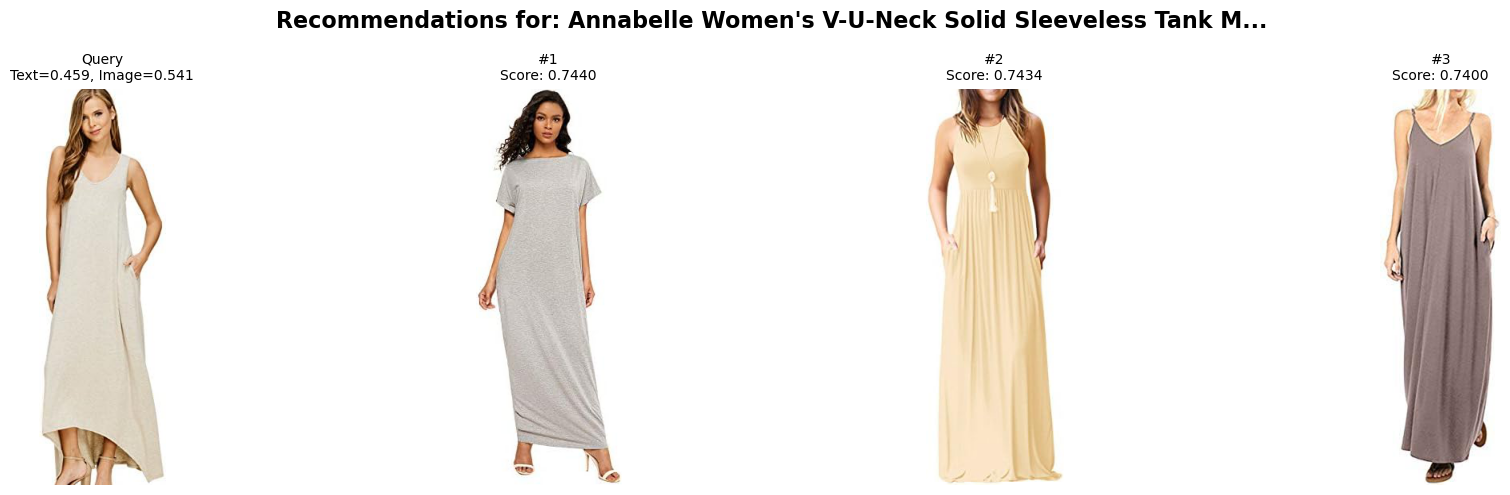

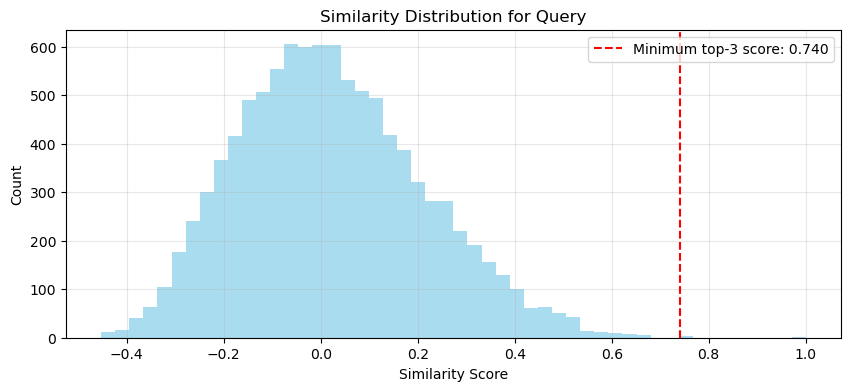

In [6]:
def enhanced_recommend_with_images(idx, top_k=5, show_analysis=False):
    """
    Enhanced recommendation function that displays images along with recommendations
    
    Args:
        idx: Index of the query item in the dataset
        top_k: Number of recommendations to show
        show_analysis: Whether to show similarity distribution analysis
    """
    if idx >= len(fused_embeddings):
        print(f"Index {idx} out of bounds")
        return
    
    query_emb = fused_embeddings[idx]
    similarities = util.cos_sim(query_emb, fused_embeddings)[0]
    
    # Exclude self and get top recommendations
    mask = torch.ones(len(similarities), dtype=torch.bool)
    mask[idx] = False
    filtered_scores = similarities[mask]
    filtered_indices = torch.arange(len(similarities), device=DEVICE)[mask]
    
    top_scores, top_positions = torch.topk(filtered_scores, k=top_k)
    top_indices = filtered_indices[top_positions].cpu().numpy()
    
    # Get query item details
    query_item = df.iloc[idx]
    query_title = query_item['title']
    query_img_url = query_item['image_large']
    query_weights = f"Text={fusion_weights[idx, 0]:.3f}, Image={fusion_weights[idx, 1]:.3f}"
    
    # Get recommendation details
    rec_titles = [df.iloc[i]['title'] for i in top_indices]
    rec_img_urls = [df.iloc[i]['image_large'] for i in top_indices]
    rec_scores = [f"{score:.4f}" for score in top_scores.cpu().numpy()]
    rec_weights = [f"Text={fusion_weights[i, 0]:.3f}, Image={fusion_weights[i, 1]:.3f}" for i in top_indices]
    
    # Display results
    print(f"\n🔍 QUERY:")
    print(f"Title: {query_title}")
    print(f"Fusion weights: {query_weights}")
    
    print(f"\n📋 Top {top_k} Recommendations:")
    for i, (title, score, weights) in enumerate(zip(rec_titles, rec_scores, rec_weights)):
        print(f"{i+1}. {title}")
        print(f"   Score: {score}")
        print(f"   Weights: {weights}")
        print()
    
    # Display images
    try:
        # Create figure for visualization
        fig, axes = plt.subplots(1, top_k + 1, figsize=(20, 5))
        fig.suptitle(f'Recommendations for: {query_title[:50]}...', fontsize=16, fontweight='bold')
        
        # Display query image
        try:
            response = requests.get(query_img_url, timeout=5)
            img = Image.open(BytesIO(response.content))
            axes[0].imshow(img)
            axes[0].set_title(f'Query\n{query_weights}', fontsize=10)
            axes[0].axis('off')
        except:
            axes[0].text(0.5, 0.5, 'Image\nnot available', 
                        ha='center', va='center', fontsize=12)
            axes[0].set_title(f'Query\n{query_weights}', fontsize=10)
            axes[0].axis('off')
        
        # Display recommendation images
        for i, (img_url, title, score) in enumerate(zip(rec_img_urls, rec_titles, rec_scores)):
            try:
                response = requests.get(img_url, timeout=5)
                img = Image.open(BytesIO(response.content))
                axes[i+1].imshow(img)
                axes[i+1].set_title(f'#{i+1}\nScore: {score}', fontsize=10)
                axes[i+1].axis('off')
            except:
                axes[i+1].text(0.5, 0.5, 'Image\nnot available', 
                              ha='center', va='center', fontsize=10)
                axes[i+1].set_title(f'#{i+1}\nScore: {score}', fontsize=10)
                axes[i+1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not display images: {e}")
    
    if show_analysis:
        # Show similarity distribution
        plt.figure(figsize=(10, 4))
        plt.hist(similarities.cpu().numpy(), bins=50, alpha=0.7, color='skyblue')
        plt.axvline(x=top_scores[-1].item(), color='red', linestyle='--', 
                   label=f'Minimum top-{top_k} score: {top_scores[-1].item():.3f}')
        plt.xlabel('Similarity Score')
        plt.ylabel('Count')
        plt.title('Similarity Distribution for Query')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

# Example usage:
# enhanced_recommend_with_images(89, top_k=3)
enhanced_recommend_with_images(679, top_k=3, show_analysis=True)